In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='销量')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 替换即可
data = data[['花菜类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"销量_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 花菜类...
Epoch [50/600], Loss: 0.048778
Epoch [100/600], Loss: 0.047208
Epoch [150/600], Loss: 0.045528
Epoch [200/600], Loss: 0.037670
Epoch [250/600], Loss: 0.025936
Epoch [300/600], Loss: 0.005492
Epoch [350/600], Loss: 0.000344
Epoch [400/600], Loss: 0.000163
Epoch [450/600], Loss: 0.000118
Epoch [500/600], Loss: 0.000097
Epoch [550/600], Loss: 0.000082
Epoch [600/600], Loss: 0.000071
Results for 花菜类 saved to 销量_花菜类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [117]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='销量')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['花叶类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"销量_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 花叶类...
Epoch [50/600], Loss: 0.069118
Epoch [100/600], Loss: 0.067326
Epoch [150/600], Loss: 0.064430
Epoch [200/600], Loss: 0.056218
Epoch [250/600], Loss: 0.026117
Epoch [300/600], Loss: 0.006053
Epoch [350/600], Loss: 0.002237
Epoch [400/600], Loss: 0.000830
Epoch [450/600], Loss: 0.000478
Epoch [500/600], Loss: 0.000362
Epoch [550/600], Loss: 0.000305
Epoch [600/600], Loss: 0.000265
Results for 花叶类 saved to 销量_花叶类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [152]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='销量')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['辣椒类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"销量_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 辣椒类...
Epoch [50/600], Loss: 0.076661
Epoch [100/600], Loss: 0.075006
Epoch [150/600], Loss: 0.073228
Epoch [200/600], Loss: 0.068488
Epoch [250/600], Loss: 0.046476
Epoch [300/600], Loss: 0.004109
Epoch [350/600], Loss: 0.000654
Epoch [400/600], Loss: 0.000379
Epoch [450/600], Loss: 0.000255
Epoch [500/600], Loss: 0.000182
Epoch [550/600], Loss: 0.000139
Epoch [600/600], Loss: 0.000110
Results for 辣椒类 saved to 销量_辣椒类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [103]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='销量')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['茄类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"销量_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 茄类...
Epoch [50/600], Loss: 0.069416
Epoch [100/600], Loss: 0.068897
Epoch [150/600], Loss: 0.068358
Epoch [200/600], Loss: 0.066967
Epoch [250/600], Loss: 0.059731
Epoch [300/600], Loss: 0.018025
Epoch [350/600], Loss: 0.002796
Epoch [400/600], Loss: 0.000548
Epoch [450/600], Loss: 0.000301
Epoch [500/600], Loss: 0.000175
Epoch [550/600], Loss: 0.000101
Epoch [600/600], Loss: 0.000060
Results for 茄类 saved to 销量_茄类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [155]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='销量')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['食用菌']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"销量_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 食用菌...
Epoch [50/600], Loss: 0.084128
Epoch [100/600], Loss: 0.080980
Epoch [150/600], Loss: 0.079543
Epoch [200/600], Loss: 0.077719
Epoch [250/600], Loss: 0.074036
Epoch [300/600], Loss: 0.065383
Epoch [350/600], Loss: 0.045206
Epoch [400/600], Loss: 0.011626
Epoch [450/600], Loss: 0.002036
Epoch [500/600], Loss: 0.000763
Epoch [550/600], Loss: 0.000538
Epoch [600/600], Loss: 0.000413
Results for 食用菌 saved to 销量_食用菌_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [109]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='销量')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['水生根茎类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"销量_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 水生根茎类...
Epoch [50/600], Loss: 0.094663
Epoch [100/600], Loss: 0.066476
Epoch [150/600], Loss: 0.065110
Epoch [200/600], Loss: 0.063022
Epoch [250/600], Loss: 0.058604
Epoch [300/600], Loss: 0.044564
Epoch [350/600], Loss: 0.014555
Epoch [400/600], Loss: 0.003312
Epoch [450/600], Loss: 0.001545
Epoch [500/600], Loss: 0.001132
Epoch [550/600], Loss: 0.000859
Epoch [600/600], Loss: 0.000630
Results for 水生根茎类 saved to 销量_水生根茎类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


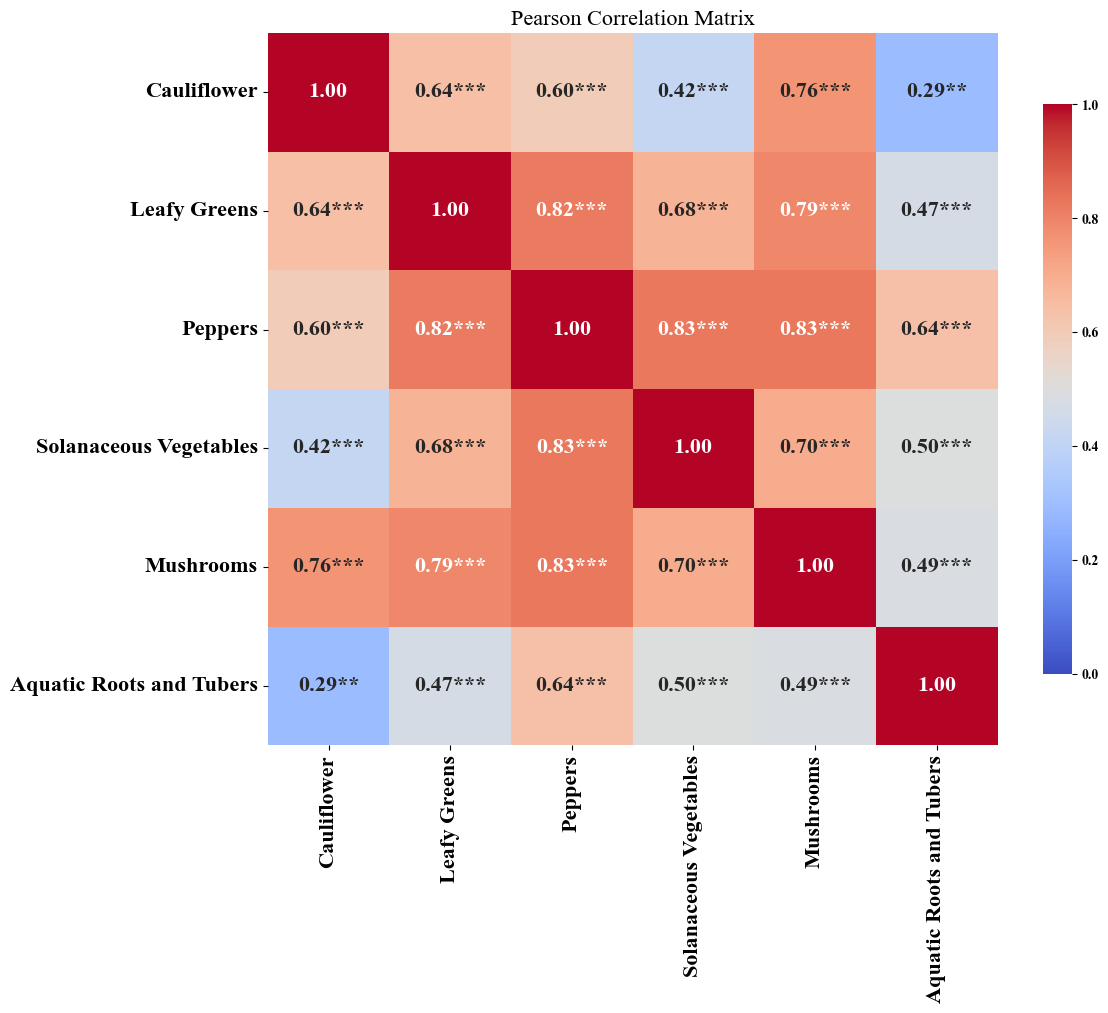

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 设置中文字体为宋体，英文字体为新罗马字体
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 使用宋体
plt.rcParams['font.serif'] = ['Times New Roman']  # 使用新罗马字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['font.weight'] = 'bold'  # 设置字体加粗

# Example data, assuming you have loaded it into 'data' DataFrame
data = pd.DataFrame({
    'Cauliflower': [29.389, 22.365, 32.371, 32.652, 28.675, 34.087, 54.158, 17.863, 25.81, 26.422, 23.274, 21.507, 45.087, 43.642, 27.764, 26.009, 19.914, 22.684, 20.153, 27.242, 29.13, 14.808, 20.181, 15.923, 14.565, 24.236, 41.279, 36.971, 16.312, 14.652, 16.723, 19.364, 16.172, 33.243, 25.117, 22.57, 21.351, 11.835, 15.446, 13.684, 26.766, 25.472, 17.143, 10.189, 9.175, 9.804, 22.692, 26.791, 23.098, 12.363, 13.919, 16.697, 17.912, 9.279, 11.548, 10.681, 8.083, 14.272, 16.069, 24.367, 28.087],
    'Leafy Greens': [179.89, 199.057, 252.366, 121.428, 115.371, 163.827, 238.132, 142.341, 145.033, 159.328, 158.484, 142.706, 179.071, 199.509, 171.35, 194.936, 150.478, 112.688, 141.327, 177.822, 197.446, 154.18, 150.721, 135.51, 114.768, 154.12, 272.537, 262.277, 146.434, 156.287, 136.132, 136.982, 161.142, 222.081, 215.285, 145.142, 152.439, 135.735, 119.287, 140.024, 240.235, 213.908, 127.399, 140.865, 115.605, 118.42, 172.11, 244.334, 253.447, 128.701, 126.228, 126.263, 171.919, 178.718, 161.495, 108.895, 80.524, 127.278, 130.182, 135.09, 130.464],
    'Peppers': [138.857, 103.643, 95.795, 76.542, 66.977, 94.505, 134.833, 85.984, 81.721, 99.29, 75.742, 88.881, 135.703, 110.866, 78.687, 80.294, 67.717, 53.892, 71.713, 92.262, 117.485, 90.848, 69.361, 62.956, 76.118, 90.26, 127.658, 131.518, 61.995, 59.897, 61.96, 67.854, 72.847, 123.664, 123.698, 74.896, 84.745, 66.121, 76.363, 74.296, 146.968, 119.69, 67.12, 84.891, 82.127, 63.624, 86.159, 169.193, 149.877, 77.049, 66.666, 91.365, 114.288, 88.349, 94.187, 69.658, 72.185, 67.12, 68.534, 89.113, 82.286],
    'Solanaceous Vegetables': [31.862, 35.967, 22.717, 25.655, 22.324, 23.097, 39.966, 21.757, 17.224, 28.106, 13.908, 24.496, 33.208, 32.974, 21.584, 14.181, 14.296, 11.595, 15.232, 33.825, 38.276, 25.981, 23.022, 15.749, 21.865, 18.213, 24.313, 38.881, 28.536, 23.886, 17.471, 18.475, 22.501, 39.399, 34.741, 19.989, 19.081, 17.873, 24.509, 21.798, 38.116, 43.303, 23.087, 17.659, 28.361, 15.908, 24.133, 46.628, 54.553, 21.207, 21.592, 24.123, 33.866, 25.398, 28.369, 23.315, 21.224, 8.415, 15.651, 11.511, 24.53],
    'Mushrooms': [83.717, 66.312, 72.027, 55.952, 63.126, 99.697, 115.423, 58.128, 49.033, 78.595, 42.217, 67.921, 95.606, 97.677, 61.585, 57.535, 54.7, 49.756, 60.947, 82.754, 94.76, 70.154, 49.994, 47.818, 50.69, 53.736, 91.754, 109.635, 53.849, 46.299, 46.711, 44.867, 68.385, 94.541, 95.926, 49.192, 56.608, 44.446, 49.993, 55.465, 98.844, 79.626, 36.154, 54.24, 43.778, 34.886, 58.503, 93.35, 72.039, 43.293, 39.223, 63.364, 77.476, 55.417, 54.18, 35.271, 39.582, 38.708, 53.742, 48.314, 39.572],
    'Aquatic Roots and Tubers': [22.754, 20.191, 11.586, 9.037, 13.454, 17.781, 18.818, 9.628, 7.406, 10.336, 9.518, 16.347, 20.655, 15.86, 7.475, 9.603, 12.893, 8.812, 9.66, 11.094, 13.615, 8.411, 14.637, 9.414, 13.962, 20.081, 24.97, 22.807, 12.75, 8.852, 7.86, 9.741, 11.988, 29.041, 21.047, 12.58, 14.408, 14.142, 9.254, 15.816, 19.118, 21.247, 10.351, 12.054, 7.284, 16.733, 15.49, 22.626, 23.373, 11.51, 11.657, 27.178, 38.77, 18.677, 16.054, 16.5, 10.384, 16.454, 14.946, 22.945, 19.419]
})

# Column names for the vegetable categories
selected_columns = ['Cauliflower', 'Leafy Greens', 'Peppers', 'Solanaceous Vegetables', 'Mushrooms', 'Aquatic Roots and Tubers']

# Calculate the correlation matrix
correlation_matrix = data[selected_columns].corr()

# Calculate the p-value matrix
p_values = pd.DataFrame(np.zeros((len(selected_columns), len(selected_columns))), columns=selected_columns, index=selected_columns)

for row in selected_columns:
    for col in selected_columns:
        if row != col:
            corr, p_val = pearsonr(data[row], data[col])
            p_values.loc[row, col] = p_val
        else:
            p_values.loc[row, col] = np.nan

# Add significance stars based on p-values
def add_significance_stars(val, p_val):
    if p_val < 0.01:
        return f'{val:.2f}***'
    elif p_val < 0.05:
        return f'{val:.2f}**'
    elif p_val < 0.1:
        return f'{val:.2f}*'
    else:
        return f'{val:.2f}'

# Initialize a DataFrame with empty strings
correlation_matrix_stars = pd.DataFrame("", index=selected_columns, columns=selected_columns)

for row in selected_columns:
    for col in selected_columns:
        if row != col:
            correlation_matrix_stars.loc[row, col] = add_significance_stars(correlation_matrix.loc[row, col], p_values.loc[row, col])
        else:
            correlation_matrix_stars.loc[row, col] = f'{correlation_matrix.loc[row, col]:.2f}'

# Set the font size
annot_font_size = 16  # annotation font size
title_font_size = 16  # title font size

# Plot the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=correlation_matrix_stars, fmt='', cmap='coolwarm', vmin=0, vmax=1, 
            cbar_kws={"shrink": .8}, annot_kws={"size": annot_font_size})

# 设置坐标轴标签旋转角度和字体大小
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

plt.tight_layout()

plt.title('Pearson Correlation Matrix', fontsize=title_font_size)

plt.savefig("Pearson Correlation Matrix.png", dpi=900)

plt.show()

In [217]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from pyswarm import pso

# 已有数据：真实值、测试值
data = pd.DataFrame({
    '真实值': [17.143, 10.189, 9.175, 9.804, 22.692, 26.791, 23.098, 12.363, 13.919, 16.697, 17.912, 9.279, 11.548, 10.681, 8.083, 14.272, 16.069, 24.367, 28.087],
    '测试值': [21.27114487, 13.49584579, 10.27922535, 9.868627548, 20.76497841, 25.90560913, 22.32974243, 12.33374691, 13.72441864, 16.26398659, 17.42085075, 9.831232071, 11.36594677, 10.64528656, 8.463320732, 13.21659088, 15.21940994, 23.47828102, 27.73612404],
})

# 未来15天预测值
future_predictions = [
    21.27114487, 17.79717064, 17.34286118, 17.62304688, 24.43147469, 26.92238235,
    24.67334557, 18.81744385, 19.58541489, 21.03070259, 21.69088554, 17.38881874,
    18.42765427, 18.02258682, 16.86918831
]
future_data = pd.DataFrame({'未来预测': future_predictions})

# 计算误差率
data['误差率'] = ((data['测试值'] - data['真实值']) / data['真实值']) * 100

# 划分误差状态区间
def classify_state(error_rate):
    if -9 <= error_rate <= -3:
        return 0  # 低误差
    elif -3 < error_rate <= 3:
        return 1  # 较低误差
    elif 3 < error_rate <= 9:
        return 2  # 较高误差
    elif error_rate > 9:
        return 3  # 高误差

data['状态'] = data['误差率'].apply(classify_state)

# 状态上下界（百分数）
state_bounds = {
    0: (-9, -3),
    1: (-3, 3),
    2: (3, 9),
    3: (9, 100)
}

# 构建转移概率矩阵
num_states = 4
transition_matrix = np.zeros((num_states, num_states))
states = data['状态'].astype(int).values
for i in range(len(states) - 1):
    transition_matrix[states[i], states[i + 1]] += 1

# 归一化转移概率矩阵
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# PSO优化白化系数
def fitness_function(lambdas):
    predicted_errors = []
    for i, state in enumerate(data['状态'].astype(int)):
        # 确保每个状态的上下界都正确处理
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error = lambdas[state] * E_L + (1 - lambdas[state]) * E_U
        predicted_errors.append(predicted_error / 100)  # 转化为小数形式
    predicted_errors = np.array(predicted_errors)

    # 修正预测值，避免分母为 0 或接近 0
    corrected_values = data['测试值'] / np.clip((1 + predicted_errors), 1e-6, None)

    mse = mean_squared_error(data['真实值'], corrected_values)  # 目标是最小化MSE
    return mse

# 优化白化系数
lb = [0] * num_states  # 白化系数下界
ub = [1] * num_states  # 白化系数上界
optimal_lambdas, _ = pso(fitness_function, lb, ub, swarmsize=100, maxiter=200)

# 输出优化的白化系数
print("\n优化后的白化系数：")
for i, lamb in enumerate(optimal_lambdas):
    print(f"状态 {i} 的白化系数: {lamb:.4f}")

# 修正预测值和预测状态（矩阵相乘）
corrected_values = []
predicted_errors = []
predicted_states = []
current_state = np.zeros(num_states)
current_state[states[0]] = 1  # 初始化为第一个状态

for test_value in data['测试值']:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        # 获取上下界
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        # 计算预测误差
        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = test_value / np.clip((1 + predicted_error / 100), 1e-6, None)
    corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

data['修正值'] = corrected_values
data['预测的状态'] = predicted_states

# 修正未来15天预测值
future_corrected_values = []
future_predicted_states = []
for pred in future_predictions:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = pred / np.clip((1 + predicted_error / 100), 1e-6, None)
    future_corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    future_predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

future_data['修正值'] = future_corrected_values
future_data['预测的状态'] = future_predicted_states

# 保存结果到Excel
output_file = "花菜类_马尔科夫链修正结果.xlsx"
with pd.ExcelWriter(output_file) as writer:
    data.to_excel(writer, sheet_name='修正结果', index=False)
    future_data.to_excel(writer, sheet_name='未来预测修正', index=False)
    pd.DataFrame({'状态': [f'状态{i}' for i in range(num_states)], '白化系数': optimal_lambdas}).to_excel(writer, sheet_name='白化系数', index=False)
    pd.DataFrame({'指标': ['R2', 'MSE', 'RMSE', 'MAPE'], '值': [r2_score(data['真实值'], data['修正值']),
                                                              mean_squared_error(data['真实值'], data['修正值']),
                                                              np.sqrt(mean_squared_error(data['真实值'], data['修正值'])),
                                                              np.mean(np.abs((data['真实值'] - data['修正值']) / data['真实值'])) * 100]}).to_excel(writer, sheet_name='评价指标', index=False)
    pd.DataFrame(transition_matrix, index=[f'状态{i}' for i in range(num_states)],
                 columns=[f'状态{i}' for i in range(num_states)]).to_excel(writer, sheet_name='转移概率矩阵')

print(f"\n修正结果已保存到文件：{output_file}")

Stopping search: Swarm best objective change less than 1e-08

优化后的白化系数：
状态 0 的白化系数: 0.2929
状态 1 的白化系数: 0.7451
状态 2 的白化系数: 0.5981
状态 3 的白化系数: 0.8340
当前状态分布: [0. 0. 0. 1.]
随机选择的下一个状态: 3
当前状态分布: [0.         0.33333333 0.         0.66666667]
随机选择的下一个状态: 3
当前状态分布: [0.04761905 0.41269841 0.0952381  0.44444444]
随机选择的下一个状态: 1
当前状态分布: [0.138322   0.44746788 0.11791383 0.2962963 ]
随机选择的下一个状态: 3
当前状态分布: [0.21509556 0.45952561 0.12784796 0.19753086]
随机选择的下一个状态: 3
当前状态分布: [0.27296754 0.46405219 0.13129303 0.13168724]
随机选择的下一个状态: 3
当前状态分布: [0.31391804 0.46570412 0.13258634 0.0877915 ]
随机选择的下一个状态: 1
当前状态分布: [0.34210103 0.46631299 0.13305832 0.05852766]
随机选择的下一个状态: 1
当前状态分布: [0.36121265 0.46653662 0.13323228 0.03901844]
随机选择的下一个状态: 1
当前状态分布: [0.37407267 0.46661886 0.13329618 0.02601229]
随机选择的下一个状态: 1
当前状态分布: [0.3826897  0.46664909 0.13331967 0.01734153]
随机选择的下一个状态: 1
当前状态分布: [0.38845046 0.46666021 0.13332831 0.01156102]
随机选择的下一个状态: 1
当前状态分布: [0.39229687 0.46666429 0.13333149 0.00770735]
随机选择的下一个状态: 0


In [221]:
import numpy as np
import pandas as pd

# 转移频数矩阵 (表4)
frequency_matrix = np.array([
    [4, 2, 0, 0],  # E1
    [1, 4, 2, 0],  # E2
    [1, 1, 0, 0],  # E3
    [0, 1, 0, 2]   # E4
])

# 计算转移概率矩阵
total_transitions = frequency_matrix.sum(axis=1, keepdims=True)  # 每行总和
transition_prob_matrix = frequency_matrix / total_transitions  # 转移概率矩阵

# 计算边际概率分布（列频数之和 / 总频数）
total_sum = frequency_matrix.sum()
marginal_probs = frequency_matrix.sum(axis=0) / total_sum

# 初始化统计量计算矩阵
rows, cols = frequency_matrix.shape
stat_table = np.zeros((rows, cols))  # 用于保存每个 f_ij * log(|p_ij / p_j|) 的值

# 计算统计量矩阵
for i in range(rows):
    for j in range(cols):
        if transition_prob_matrix[i, j] > 0 and marginal_probs[j] > 0:
            log_term = np.log(transition_prob_matrix[i, j] / marginal_probs[j])
            stat_table[i, j] = frequency_matrix[i, j] * abs(log_term)  # 取绝对值

# 计算统计量 X^2
X2 = 2 * stat_table.sum()

# 打印计算结果
print("转移概率矩阵：")
print(transition_prob_matrix)
print("\n边际概率分布：")
print(marginal_probs)
print("\n统计量矩阵：")
print(pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]))
print(f"\n统计量 X^2: {X2:.4f}")

# 导出结果到 Excel
output_file = "花菜类_markov_chain_stat_results_abs.xlsx"
with pd.ExcelWriter(output_file) as writer:
    pd.DataFrame(transition_prob_matrix, columns=[f'E{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="转移概率矩阵")
    pd.DataFrame(marginal_probs, columns=["边际概率"], index=[f'E{i+1}' for i in range(cols)]).to_excel(writer, sheet_name="边际概率分布")
    pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="统计量矩阵")
    pd.DataFrame({"统计量": [X2]}, index=["X^2"]).to_excel(writer, sheet_name="统计量X^2")

print(f"\n计算结果已保存至 {output_file}")


转移概率矩阵：
[[0.66666667 0.33333333 0.         0.        ]
 [0.14285714 0.57142857 0.28571429 0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.33333333 0.         0.66666667]]

边际概率分布：
[0.33333333 0.44444444 0.11111111 0.11111111]

统计量矩阵：
        p1_1      p1_2      p1_3      p1_4
E1  2.772589  0.575364  0.000000  0.000000
E2  0.847298  1.005258  1.888923  0.000000
E3  0.405465  0.117783  0.000000  0.000000
E4  0.000000  0.287682  0.000000  3.583519

统计量 X^2: 22.9678

计算结果已保存至 花菜类_markov_chain_stat_results_abs.xlsx


In [219]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from pyswarm import pso

# 已有数据：真实值、测试值、未来预测
data = pd.DataFrame({
    '真实值': [
        127.399, 140.865, 115.605, 118.42, 172.11, 244.334, 253.447, 128.701, 126.228, 126.263,
        171.919, 178.718, 161.495, 108.895, 80.524, 127.278, 130.182, 135.09, 130.464
    ],
    '测试值': [
        146.5936737, 159.4841309, 137.3471527, 135.3398285, 184.1242523, 253.2305908, 258.8731384,
        131.2388763, 125.4288177, 125.7985077, 171.4363861, 180.674469, 162.2012329, 115.4900208,
        93.66939545, 128.568512, 137.6961365, 144.7706146, 140.7081604
    ],
})

# 添加未来15天预测数据
future_predictions = [
    146.5936737, 153.2030182, 141.024292, 142.3307343, 168.9224243, 201.2745819,
    204.6350098, 147.2226563, 146.0301361, 146.0469666, 168.8268738, 172.2106018,
    163.5841064, 137.9758911, 126.3062897
]
future_data = pd.DataFrame({'未来预测': future_predictions})

# 计算误差率
data['误差率'] = ((data['测试值'] - data['真实值']) / data['真实值']) * 100

# 划分误差状态区间
def classify_state(error_rate):
    if -9 <= error_rate <= 0:
        return 0  # 低误差
    elif 0 < error_rate <= 3:
        return 1  # 较低误差
    elif 3 < error_rate <= 9:
        return 2  # 较高误差
    elif error_rate > 9:
        return 3  # 高误差

data['状态'] = data['误差率'].apply(classify_state)

# 状态上下界（百分数）
state_bounds = {
    0: (-9, 0),
    1: (0, 3),
    2: (3, 9),
    3: (9, 100)
}

# 构建转移概率矩阵
num_states = 4
transition_matrix = np.zeros((num_states, num_states))
states = data['状态'].astype(int).values
for i in range(len(states) - 1):
    transition_matrix[states[i], states[i + 1]] += 1

# 归一化转移概率矩阵
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# PSO优化白化系数
def fitness_function(lambdas):
    predicted_errors = []
    for i, state in enumerate(data['状态'].astype(int)):
        # 确保每个状态的上下界都正确处理
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error = lambdas[state] * E_L + (1 - lambdas[state]) * E_U
        predicted_errors.append(predicted_error / 100)  # 转化为小数形式
    predicted_errors = np.array(predicted_errors)

    # 修正预测值，避免分母为 0 或接近 0
    corrected_values = data['测试值'] / np.clip((1 + predicted_errors), 1e-6, None)

    mse = mean_squared_error(data['真实值'], corrected_values)  # 目标是最小化MSE
    return mse

# 优化白化系数
lb = [0] * num_states  # 白化系数下界
ub = [1] * num_states  # 白化系数上界
optimal_lambdas, _ = pso(fitness_function, lb, ub, swarmsize=100, maxiter=200)

# 输出优化的白化系数
print("\n优化后的白化系数：")
for i, lamb in enumerate(optimal_lambdas):
    print(f"状态 {i} 的白化系数: {lamb:.4f}")

# 修正预测值和预测状态（矩阵相乘）
corrected_values = []
predicted_errors = []
predicted_states = []
current_state = np.zeros(num_states)
current_state[states[0]] = 1  # 初始化为第一个状态

for test_value in data['测试值']:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        # 获取上下界
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        # 计算预测误差
        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = test_value / np.clip((1 + predicted_error / 100), 1e-6, None)
    corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

data['修正值'] = corrected_values
data['预测的状态'] = predicted_states

# 修正未来15天预测值
future_corrected_values = []
future_predicted_states = []
for pred in future_predictions:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = pred / np.clip((1 + predicted_error / 100), 1e-6, None)
    future_corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    future_predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

future_data['修正值'] = future_corrected_values
future_data['预测的状态'] = future_predicted_states

# 保存结果到Excel
output_file = "花叶类_马尔科夫链修正结果.xlsx"
with pd.ExcelWriter(output_file) as writer:
    data.to_excel(writer, sheet_name='修正结果', index=False)
    future_data.to_excel(writer, sheet_name='未来预测修正', index=False)
    pd.DataFrame({'状态': [f'状态{i}' for i in range(num_states)], '白化系数': optimal_lambdas}).to_excel(writer, sheet_name='白化系数', index=False)
    pd.DataFrame({'指标': ['R2', 'MSE', 'RMSE', 'MAPE'], '值': [r2_score(data['真实值'], data['修正值']),
                                                              mean_squared_error(data['真实值'], data['修正值']),
                                                              np.sqrt(mean_squared_error(data['真实值'], data['修正值'])),
                                                              np.mean(np.abs((data['真实值'] - data['修正值']) / data['真实值'])) * 100]}).to_excel(writer, sheet_name='评价指标', index=False)
    pd.DataFrame(transition_matrix, index=[f'状态{i}' for i in range(num_states)],
                 columns=[f'状态{i}' for i in range(num_states)]).to_excel(writer, sheet_name='转移概率矩阵')

print(f"\n修正结果已保存到文件：{output_file}")

Stopping search: Swarm best objective change less than 1e-08

优化后的白化系数：
状态 0 的白化系数: 0.0439
状态 1 的白化系数: 0.4976
状态 2 的白化系数: 0.5632
状态 3 的白化系数: 0.9313
当前状态分布: [0. 0. 0. 1.]
随机选择的下一个状态: 3
当前状态分布: [0.  0.2 0.2 0.6]
随机选择的下一个状态: 2
当前状态分布: [0.04 0.24 0.32 0.4 ]
随机选择的下一个状态: 3
当前状态分布: [0.07466667 0.25333333 0.368      0.304     ]
随机选择的下一个状态: 2
当前状态分布: [0.10044444 0.26062222 0.38293333 0.256     ]
随机选择的下一个状态: 3
当前状态分布: [0.11908741 0.26551704 0.38520889 0.23018667]
随机选择的下一个状态: 0
当前状态分布: [0.13249501 0.26898173 0.38336948 0.21515378]
随机选择的下一个状态: 1
当前状态分布: [0.14212635 0.27146235 0.38064514 0.20576616]
随机选择的下一个状态: 0
当前状态分布: [0.14904337 0.27324265 0.37812525 0.19958872]
随机选择的下一个状态: 0
当前状态分布: [0.15401078 0.27452098 0.37608996 0.19537829]
随机选择的下一个状态: 2
当前状态分布: [0.15757805 0.27543897 0.37453802 0.19244496]
随机选择的下一个状态: 2
当前状态分布: [0.16013983 0.2760982  0.37338739 0.19037458]
随机选择的下一个状态: 0
当前状态分布: [0.16197952 0.27657162 0.37254663 0.18890223]
随机选择的下一个状态: 1
当前状态分布: [0.16330067 0.27691159 0.37193707 0.18785066

In [222]:
import numpy as np
import pandas as pd

# 转移频数矩阵 (表4)
frequency_matrix = np.array([
    [2, 1, 0, 0],  # E1
    [1, 2, 2, 0],  # E2
    [0, 1, 3, 1],  # E3
    [0, 1, 1, 3]   # E4
])

# 计算转移概率矩阵
total_transitions = frequency_matrix.sum(axis=1, keepdims=True)  # 每行总和
transition_prob_matrix = frequency_matrix / total_transitions  # 转移概率矩阵

# 计算边际概率分布（列频数之和 / 总频数）
total_sum = frequency_matrix.sum()
marginal_probs = frequency_matrix.sum(axis=0) / total_sum

# 初始化统计量计算矩阵
rows, cols = frequency_matrix.shape
stat_table = np.zeros((rows, cols))  # 用于保存每个 f_ij * log(|p_ij / p_j|) 的值

# 计算统计量矩阵
for i in range(rows):
    for j in range(cols):
        if transition_prob_matrix[i, j] > 0 and marginal_probs[j] > 0:
            log_term = np.log(transition_prob_matrix[i, j] / marginal_probs[j])
            stat_table[i, j] = frequency_matrix[i, j] * abs(log_term)  # 取绝对值

# 计算统计量 X^2
X2 = 2 * stat_table.sum()

# 打印计算结果
print("转移概率矩阵：")
print(transition_prob_matrix)
print("\n边际概率分布：")
print(marginal_probs)
print("\n统计量矩阵：")
print(pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]))
print(f"\n统计量 X^2: {X2:.4f}")

# 导出结果到 Excel
output_file = "花叶类_markov_chain_stat_results_abs.xlsx"
with pd.ExcelWriter(output_file) as writer:
    pd.DataFrame(transition_prob_matrix, columns=[f'E{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="转移概率矩阵")
    pd.DataFrame(marginal_probs, columns=["边际概率"], index=[f'E{i+1}' for i in range(cols)]).to_excel(writer, sheet_name="边际概率分布")
    pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="统计量矩阵")
    pd.DataFrame({"统计量": [X2]}, index=["X^2"]).to_excel(writer, sheet_name="统计量X^2")

print(f"\n计算结果已保存至 {output_file}")


转移概率矩阵：
[[0.66666667 0.33333333 0.         0.        ]
 [0.2        0.4        0.4        0.        ]
 [0.         0.2        0.6        0.2       ]
 [0.         0.2        0.2        0.6       ]]

边际概率分布：
[0.16666667 0.27777778 0.33333333 0.22222222]

统计量矩阵：
        p1_1      p1_2      p1_3      p1_4
E1  2.772589  0.182322  0.000000  0.000000
E2  0.182322  0.729286  0.364643  0.000000
E3  0.000000  0.328504  1.763360  0.105361
E4  0.000000  0.328504  0.510826  2.979755

统计量 X^2: 20.4949

计算结果已保存至 花叶类_markov_chain_stat_results_abs.xlsx


In [220]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from pyswarm import pso

# 已有数据：真实值、测试值、未来预测
data = pd.DataFrame({
    '真实值': [67.12, 84.891, 82.127, 63.624, 86.159, 169.193, 149.877, 77.049, 66.666, 91.365, 114.288, 88.349, 94.187, 69.658, 72.185, 67.12, 68.534, 89.113, 82.286],
    '测试值': [98.81443787, 94.06998444, 83.73355865, 66.27309418, 85.52937317, 163.4857025, 145.6053925, 78.30440521, 68.74869537, 90.09065247, 115.4523087, 88.14334869, 93.89649963, 70.13117218, 72.43621826, 67.6269989, 68.91565704, 88.84653473, 82.47701263]
})

# 未来15天预测值
future_predictions = [
    98.81443787, 108.7219772, 107.1483612, 96.94742584, 109.4461365,
    150.755722, 143.0314484, 104.281601, 98.57004547, 112.4282837,
    125.3837662, 110.6993103, 114.046875, 100.1905365, 101.5762939
]
future_data = pd.DataFrame({'未来预测': future_predictions})

# 计算误差率
data['误差率'] = ((data['测试值'] - data['真实值']) / data['真实值']) * 100

# 划分误差状态区间
def classify_state(error_rate):
    if -9 <= error_rate <= 0:
        return 0  # 低误差
    elif 0 < error_rate <= 3:
        return 1  # 较低误差
    elif 3 < error_rate <= 9:
        return 2  # 较高误差
    elif error_rate > 9:
        return 3  # 高误差

data['状态'] = data['误差率'].apply(classify_state)

# 状态上下界（百分数）
state_bounds = {
    0: (-9, 0),
    1: (0, 3),
    2: (3, 9),
    3: (9, 100)
}

# 构建转移概率矩阵
num_states = 4
transition_matrix = np.zeros((num_states, num_states))
states = data['状态'].astype(int).values
for i in range(len(states) - 1):
    transition_matrix[states[i], states[i + 1]] += 1

# 归一化转移概率矩阵
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# PSO优化白化系数
def fitness_function(lambdas):
    predicted_errors = []
    for i, state in enumerate(data['状态'].astype(int)):
        # 确保每个状态的上下界都正确处理
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error = lambdas[state] * E_L + (1 - lambdas[state]) * E_U
        predicted_errors.append(predicted_error / 100)  # 转化为小数形式
    predicted_errors = np.array(predicted_errors)

    # 修正预测值，避免分母为 0 或接近 0
    corrected_values = data['测试值'] / np.clip((1 + predicted_errors), 1e-6, None)

    mse = mean_squared_error(data['真实值'], corrected_values)  # 目标是最小化MSE
    return mse

# 优化白化系数
lb = [0] * num_states  # 白化系数下界
ub = [1] * num_states  # 白化系数上界
optimal_lambdas, _ = pso(fitness_function, lb, ub, swarmsize=100, maxiter=200)

# 输出优化的白化系数
print("\n优化后的白化系数：")
for i, lamb in enumerate(optimal_lambdas):
    print(f"状态 {i} 的白化系数: {lamb:.4f}")

# 修正预测值和预测状态（矩阵相乘）
corrected_values = []
predicted_errors = []
predicted_states = []
current_state = np.zeros(num_states)
current_state[states[0]] = 1  # 初始化为第一个状态

for test_value in data['测试值']:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        # 获取上下界
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        # 计算预测误差
        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = test_value / np.clip((1 + predicted_error / 100), 1e-6, None)
    corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

data['修正值'] = corrected_values
data['预测的状态'] = predicted_states

# 修正未来15天预测值
future_corrected_values = []
future_predicted_states = []
for pred in future_predictions:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = pred / np.clip((1 + predicted_error / 100), 1e-6, None)
    future_corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    future_predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

future_data['修正值'] = future_corrected_values
future_data['预测的状态'] = future_predicted_states

# 保存结果到Excel
output_file = "辣椒类_马尔科夫链修正结果.xlsx"
with pd.ExcelWriter(output_file) as writer:
    data.to_excel(writer, sheet_name='修正结果', index=False)
    future_data.to_excel(writer, sheet_name='未来预测修正', index=False)
    pd.DataFrame({'状态': [f'状态{i}' for i in range(num_states)], '白化系数': optimal_lambdas}).to_excel(writer, sheet_name='白化系数', index=False)
    pd.DataFrame({'指标': ['R2', 'MSE', 'RMSE', 'MAPE'], '值': [r2_score(data['真实值'], data['修正值']),
                                                              mean_squared_error(data['真实值'], data['修正值']),
                                                              np.sqrt(mean_squared_error(data['真实值'], data['修正值'])),
                                                              np.mean(np.abs((data['真实值'] - data['修正值']) / data['真实值'])) * 100]}).to_excel(writer, sheet_name='评价指标', index=False)
    pd.DataFrame(transition_matrix, index=[f'状态{i}' for i in range(num_states)],
                 columns=[f'状态{i}' for i in range(num_states)]).to_excel(writer, sheet_name='转移概率矩阵')

print(f"\n修正结果已保存到文件：{output_file}")

Stopping search: Swarm best objective change less than 1e-08

优化后的白化系数：
状态 0 的白化系数: 0.2222
状态 1 的白化系数: 0.6844
状态 2 的白化系数: 0.8964
状态 3 的白化系数: 0.7985
当前状态分布: [0. 0. 0. 1.]
随机选择的下一个状态: 3
当前状态分布: [0.  0.5 0.  0.5]
随机选择的下一个状态: 1
当前状态分布: [0.14285714 0.46428571 0.14285714 0.25      ]
随机选择的下一个状态: 1
当前状态分布: [0.33673469 0.40561224 0.13265306 0.125     ]
随机选择的下一个状态: 3
当前状态分布: [0.39285714 0.42875364 0.11588921 0.0625    ]
随机选择的下一个状态: 2
当前状态分布: [0.4067576  0.43949136 0.12250104 0.03125   ]
随机选择的下一个状态: 0
当前状态分布: [0.42239469 0.43641135 0.12556896 0.015625  ]
随机选择的下一个状态: 2
当前状态分布: [0.43128421 0.43621433 0.12468896 0.0078125 ]
随机选择的下一个状态: 1
当前状态分布: [0.43415771 0.43730337 0.12463267 0.00390625]
随机选择的下一个状态: 1
当前状态分布: [0.43564408 0.43745898 0.12494382 0.00195312]
随机选择的下一个状态: 0
当前状态分布: [0.4366367  0.43739845 0.12498828 0.00097656]
随机选择的下一个状态: 1
当前状态分布: [0.43708928 0.43745145 0.12497099 0.00048828]
随机选择的下一个状态: 1
当前状态分布: [4.37281093e-01 4.37488637e-01 1.24986128e-01 2.44140625e-04]
随机选择的下一个状态: 0
当前状态分布: [4.3

In [223]:
import numpy as np
import pandas as pd

# 转移频数矩阵 (表4)
frequency_matrix = np.array([
    [3, 4, 0, 0],  # E1
    [2, 3, 2, 0],  # E2
    [2, 0, 0, 0],  # E3
    [0, 1, 0, 1]   # E4
])

# 计算转移概率矩阵
total_transitions = frequency_matrix.sum(axis=1, keepdims=True)  # 每行总和
transition_prob_matrix = frequency_matrix / total_transitions  # 转移概率矩阵

# 计算边际概率分布（列频数之和 / 总频数）
total_sum = frequency_matrix.sum()
marginal_probs = frequency_matrix.sum(axis=0) / total_sum

# 初始化统计量计算矩阵
rows, cols = frequency_matrix.shape
stat_table = np.zeros((rows, cols))  # 用于保存每个 f_ij * log(|p_ij / p_j|) 的值

# 计算统计量矩阵
for i in range(rows):
    for j in range(cols):
        if transition_prob_matrix[i, j] > 0 and marginal_probs[j] > 0:
            log_term = np.log(transition_prob_matrix[i, j] / marginal_probs[j])
            stat_table[i, j] = frequency_matrix[i, j] * abs(log_term)  # 取绝对值

# 计算统计量 X^2
X2 = 2 * stat_table.sum()

# 打印计算结果
print("转移概率矩阵：")
print(transition_prob_matrix)
print("\n边际概率分布：")
print(marginal_probs)
print("\n统计量矩阵：")
print(pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]))
print(f"\n统计量 X^2: {X2:.4f}")

# 导出结果到 Excel
output_file = "辣椒类_markov_chain_stat_results_abs.xlsx"
with pd.ExcelWriter(output_file) as writer:
    pd.DataFrame(transition_prob_matrix, columns=[f'E{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="转移概率矩阵")
    pd.DataFrame(marginal_probs, columns=["边际概率"], index=[f'E{i+1}' for i in range(cols)]).to_excel(writer, sheet_name="边际概率分布")
    pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="统计量矩阵")
    pd.DataFrame({"统计量": [X2]}, index=["X^2"]).to_excel(writer, sheet_name="统计量X^2")

print(f"\n计算结果已保存至 {output_file}")


转移概率矩阵：
[[0.42857143 0.57142857 0.         0.        ]
 [0.28571429 0.42857143 0.28571429 0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.5        0.         0.5       ]]

边际概率分布：
[0.38888889 0.44444444 0.11111111 0.05555556]

统计量矩阵：
        p1_1      p1_2      p1_3      p1_4
E1  0.291491  1.005258  0.000000  0.000000
E2  0.616603  0.109103  1.888923  0.000000
E3  1.888923  0.000000  0.000000  0.000000
E4  0.000000  0.117783  0.000000  2.197225

统计量 X^2: 16.2306

计算结果已保存至 辣椒类_markov_chain_stat_results_abs.xlsx


In [225]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from pyswarm import pso

# 已有数据：真实值、测试值、未来预测
data = pd.DataFrame({
    '真实值': [23.087, 17.659, 28.361, 15.908, 24.133, 46.628, 54.553, 21.207, 21.592, 24.123,
             33.866, 25.398, 28.369, 23.315, 21.224, 8.415, 15.651, 11.511, 24.53],
    '测试值': [27.98449516, 23.83989906, 30.39754868, 17.83110809, 24.993433, 45.35546494,
             49.01702881, 21.05485153, 21.5379467, 23.78738976, 34.17411423, 25.06685638,
             28.60001564, 23.02842522, 21.08517838, 10.03997135, 15.14620209, 12.16276646, 24.31328392]
})

# 未来预测值
future_predictions = [
    27.98449516, 25.33372879, 30.60650253, 24.51077461, 28.50504303, 38.44585419,
    40.82748032, 27.054039, 27.24383545, 28.50006104, 33.25396347, 29.1355114,
    30.61045074, 28.09784317, 27.06241035
]
future_data = pd.DataFrame({'未来预测': future_predictions})


# 计算误差率
data['误差率'] = ((data['测试值'] - data['真实值']) / data['真实值']) * 100

# 划分误差状态区间
def classify_state(error_rate):
    if -11 <= error_rate <= 0:
        return 0  # 低误差
    elif 0 < error_rate <= 3:
        return 1  # 较低误差
    elif 3 < error_rate <= 9:
        return 2  # 较高误差
    elif error_rate > 9:
        return 3  # 高误差

data['状态'] = data['误差率'].apply(classify_state)

# 状态上下界（百分数）
state_bounds = {
    0: (-11, 0),
    1: (0, 3),
    2: (3, 9),
    3: (9, 100)
}

# 构建转移概率矩阵
num_states = 4
transition_matrix = np.zeros((num_states, num_states))
states = data['状态'].astype(int).values
for i in range(len(states) - 1):
    transition_matrix[states[i], states[i + 1]] += 1

# 归一化转移概率矩阵
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# PSO优化白化系数
def fitness_function(lambdas):
    predicted_errors = []
    for i, state in enumerate(data['状态'].astype(int)):
        # 确保每个状态的上下界都正确处理
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error = lambdas[state] * E_L + (1 - lambdas[state]) * E_U
        predicted_errors.append(predicted_error / 100)  # 转化为小数形式
    predicted_errors = np.array(predicted_errors)

    # 修正预测值，避免分母为 0 或接近 0
    corrected_values = data['测试值'] / np.clip((1 + predicted_errors), 1e-6, None)

    mse = mean_squared_error(data['真实值'], corrected_values)  # 目标是最小化MSE
    return mse

# 优化白化系数
lb = [0] * num_states  # 白化系数下界
ub = [1] * num_states  # 白化系数上界
optimal_lambdas, _ = pso(fitness_function, lb, ub, swarmsize=100, maxiter=200)

# 输出优化的白化系数
print("\n优化后的白化系数：")
for i, lamb in enumerate(optimal_lambdas):
    print(f"状态 {i} 的白化系数: {lamb:.4f}")

# 修正预测值和预测状态（矩阵相乘）
corrected_values = []
predicted_errors = []
predicted_states = []
current_state = np.zeros(num_states)
current_state[states[0]] = 1  # 初始化为第一个状态

for test_value in data['测试值']:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        # 获取上下界
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        # 计算预测误差
        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = test_value / np.clip((1 + predicted_error / 100), 1e-6, None)
    corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

data['修正值'] = corrected_values
data['预测的状态'] = predicted_states

# 修正未来15天预测值
future_corrected_values = []
future_predicted_states = []
for pred in future_predictions:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = pred / np.clip((1 + predicted_error / 100), 1e-6, None)
    future_corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    future_predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

future_data['修正值'] = future_corrected_values
future_data['预测的状态'] = future_predicted_states

# 保存结果到Excel
output_file = "茄类_马尔科夫链修正结果.xlsx"
with pd.ExcelWriter(output_file) as writer:
    data.to_excel(writer, sheet_name='修正结果', index=False)
    future_data.to_excel(writer, sheet_name='未来预测修正', index=False)
    pd.DataFrame({'状态': [f'状态{i}' for i in range(num_states)], '白化系数': optimal_lambdas}).to_excel(writer, sheet_name='白化系数', index=False)
    pd.DataFrame({'指标': ['R2', 'MSE', 'RMSE', 'MAPE'], '值': [r2_score(data['真实值'], data['修正值']),
                                                              mean_squared_error(data['真实值'], data['修正值']),
                                                              np.sqrt(mean_squared_error(data['真实值'], data['修正值'])),
                                                              np.mean(np.abs((data['真实值'] - data['修正值']) / data['真实值'])) * 100]}).to_excel(writer, sheet_name='评价指标', index=False)
    pd.DataFrame(transition_matrix, index=[f'状态{i}' for i in range(num_states)],
                 columns=[f'状态{i}' for i in range(num_states)]).to_excel(writer, sheet_name='转移概率矩阵')

print(f"\n修正结果已保存到文件：{output_file}")

Stopping search: Swarm best objective change less than 1e-08

优化后的白化系数：
状态 0 的白化系数: 0.4734
状态 1 的白化系数: 0.7092
状态 2 的白化系数: 0.5522
状态 3 的白化系数: 0.8424
当前状态分布: [0. 0. 0. 1.]
随机选择的下一个状态: 3
当前状态分布: [0.25 0.   0.5  0.25]
随机选择的下一个状态: 0
当前状态分布: [0.53472222 0.05555556 0.15277778 0.25694444]
随机选择的下一个状态: 3
当前状态分布: [0.51871142 0.11882716 0.1878858  0.17457562]
随机选择的下一个状态: 3
当前状态分布: [0.57590128 0.1152692  0.14492241 0.16390711]
随机选择的下一个状态: 0
当前状态分布: [0.57280608 0.12797806 0.14594258 0.15327328]
随机选择的下一个状态: 0
当前状态分布: [0.58181704 0.12729024 0.14028176 0.15061097]
随机选择的下一个状态: 1
当前状态分布: [0.58169584 0.12929267 0.13995182 0.14905967]
随机选择的下一个状态: 1
当前状态分布: [0.58302316 0.12926574 0.1391627  0.14854839]
随机选择的下一个状态: 0
当前状态分布: [0.58307973 0.1295607  0.13905455 0.14830502]
随机选择的下一个状态: 0
当前状态分布: [0.58327317 0.12957327 0.13893915 0.14821441]
随机选择的下一个状态: 0
当前状态分布: [0.58329362 0.12961626 0.13891533 0.14817478]
随机选择的下一个状态: 0
当前状态分布: [0.58332219 0.12962081 0.13889779 0.14815921]
随机选择的下一个状态: 0
当前状态分布: [0.58332702 0.12

In [226]:
import numpy as np
import pandas as pd

# 转移频数矩阵 (表4)
frequency_matrix = np.array([
    [5, 2, 1, 1],  # E1
    [2, 0, 0, 0],  # E2
    [2, 0, 0, 1],  # E3
    [1, 0, 2, 1]   # E4
])

# 计算转移概率矩阵
total_transitions = frequency_matrix.sum(axis=1, keepdims=True)  # 每行总和
transition_prob_matrix = frequency_matrix / total_transitions  # 转移概率矩阵

# 计算边际概率分布（列频数之和 / 总频数）
total_sum = frequency_matrix.sum()
marginal_probs = frequency_matrix.sum(axis=0) / total_sum

# 初始化统计量计算矩阵
rows, cols = frequency_matrix.shape
stat_table = np.zeros((rows, cols))  # 用于保存每个 f_ij * log(|p_ij / p_j|) 的值

# 计算统计量矩阵
for i in range(rows):
    for j in range(cols):
        if transition_prob_matrix[i, j] > 0 and marginal_probs[j] > 0:
            log_term = np.log(transition_prob_matrix[i, j] / marginal_probs[j])
            stat_table[i, j] = frequency_matrix[i, j] * abs(log_term)  # 取绝对值

# 计算统计量 X^2
X2 = 2 * stat_table.sum()

# 打印计算结果
print("转移概率矩阵：")
print(transition_prob_matrix)
print("\n边际概率分布：")
print(marginal_probs)
print("\n统计量矩阵：")
print(pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]))
print(f"\n统计量 X^2: {X2:.4f}")

# 导出结果到 Excel
output_file = "茄类_markov_chain_stat_results_abs.xlsx"
with pd.ExcelWriter(output_file) as writer:
    pd.DataFrame(transition_prob_matrix, columns=[f'E{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="转移概率矩阵")
    pd.DataFrame(marginal_probs, columns=["边际概率"], index=[f'E{i+1}' for i in range(cols)]).to_excel(writer, sheet_name="边际概率分布")
    pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="统计量矩阵")
    pd.DataFrame({"统计量": [X2]}, index=["X^2"]).to_excel(writer, sheet_name="统计量X^2")

print(f"\n计算结果已保存至 {output_file}")


转移概率矩阵：
[[0.55555556 0.22222222 0.11111111 0.11111111]
 [1.         0.         0.         0.        ]
 [0.66666667 0.         0.         0.33333333]
 [0.25       0.         0.5        0.25      ]]

边际概率分布：
[0.55555556 0.11111111 0.16666667 0.16666667]

统计量矩阵：
        p1_1      p1_2      p1_3      p1_4
E1  0.000000  1.386294  0.405465  0.405465
E2  1.175573  0.000000  0.000000  0.000000
E3  0.364643  0.000000  0.000000  0.693147
E4  0.798508  0.000000  2.197225  0.405465

统计量 X^2: 15.6636

计算结果已保存至 茄类_markov_chain_stat_results_abs.xlsx


In [227]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from pyswarm import pso

# 替换数据部分
data = pd.DataFrame({
    '真实值': [36.154, 54.24, 43.778, 34.886, 58.503, 93.35, 72.039, 43.293, 39.223, 63.364,
             77.476, 55.417, 54.18, 35.271, 39.582, 38.708, 53.742, 48.314, 39.572],
    '测试值': [51.4189415, 60.34195709, 52.34160233, 44.74758148, 61.54346466, 96.11161041,
             71.81398773, 47.15329361, 43.44833374, 64.37996674, 79.83991241, 55.79387665,
             55.41972351, 39.63370514, 41.77899933, 41.41155624, 54.55871964, 50.04018402, 42.66929245]
})

# 未来预测值
future_predictions = [
    51.4189415, 60.47211075, 54.93631363, 50.88111877, 62.91265488, 83.37686157,
    71.02345276, 54.69853973, 52.77717972, 65.78369904, 74.30178833, 61.13718033,
    60.43840408, 51.04296112, 52.94121933
]
future_data = pd.DataFrame({'未来预测': future_predictions})

# 计算误差率
data['误差率'] = ((data['测试值'] - data['真实值']) / data['真实值']) * 100

# 划分误差状态区间
def classify_state(error_rate):
    if -9 <= error_rate <= 0:
        return 0  # 低误差
    elif 0 < error_rate <= 3:
        return 1  # 较低误差
    elif 3 < error_rate <= 9:
        return 2  # 较高误差
    elif error_rate > 9:
        return 3  # 高误差

data['状态'] = data['误差率'].apply(classify_state)

# 状态上下界（百分数）
state_bounds = {
    0: (-9, 0),
    1: (0, 3),
    2: (3, 9),
    3: (9, 100)
}

# 构建转移概率矩阵
num_states = 4
transition_matrix = np.zeros((num_states, num_states))
states = data['状态'].astype(int).values
for i in range(len(states) - 1):
    transition_matrix[states[i], states[i + 1]] += 1

# 归一化转移概率矩阵
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# PSO优化白化系数
def fitness_function(lambdas):
    predicted_errors = []
    for i, state in enumerate(data['状态'].astype(int)):
        # 确保每个状态的上下界都正确处理
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error = lambdas[state] * E_L + (1 - lambdas[state]) * E_U
        predicted_errors.append(predicted_error / 100)  # 转化为小数形式
    predicted_errors = np.array(predicted_errors)

    # 修正预测值，避免分母为 0 或接近 0
    corrected_values = data['测试值'] / np.clip((1 + predicted_errors), 1e-6, None)

    mse = mean_squared_error(data['真实值'], corrected_values)  # 目标是最小化MSE
    return mse

# 优化白化系数
lb = [0] * num_states  # 白化系数下界
ub = [1] * num_states  # 白化系数上界
optimal_lambdas, _ = pso(fitness_function, lb, ub, swarmsize=100, maxiter=200)

# 输出优化的白化系数
print("\n优化后的白化系数：")
for i, lamb in enumerate(optimal_lambdas):
    print(f"状态 {i} 的白化系数: {lamb:.4f}")

# 修正预测值和预测状态（矩阵相乘）
corrected_values = []
predicted_errors = []
predicted_states = []
current_state = np.zeros(num_states)
current_state[states[0]] = 1  # 初始化为第一个状态

for test_value in data['测试值']:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        # 获取上下界
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        # 计算预测误差
        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = test_value / np.clip((1 + predicted_error / 100), 1e-6, None)
    corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

data['修正值'] = corrected_values
data['预测的状态'] = predicted_states

# 修正未来15天预测值
future_corrected_values = []
future_predicted_states = []
for pred in future_predictions:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = pred / np.clip((1 + predicted_error / 100), 1e-6, None)
    future_corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    future_predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

future_data['修正值'] = future_corrected_values
future_data['预测的状态'] = future_predicted_states

# 保存结果到Excel
output_file = "食用菌_马尔科夫链修正结果.xlsx"
with pd.ExcelWriter(output_file) as writer:
    data.to_excel(writer, sheet_name='修正结果', index=False)
    future_data.to_excel(writer, sheet_name='未来预测修正', index=False)
    pd.DataFrame({'状态': [f'状态{i}' for i in range(num_states)], '白化系数': optimal_lambdas}).to_excel(writer, sheet_name='白化系数', index=False)
    pd.DataFrame({'指标': ['R2', 'MSE', 'RMSE', 'MAPE'], '值': [r2_score(data['真实值'], data['修正值']),
                                                              mean_squared_error(data['真实值'], data['修正值']),
                                                              np.sqrt(mean_squared_error(data['真实值'], data['修正值'])),
                                                              np.mean(np.abs((data['真实值'] - data['修正值']) / data['真实值'])) * 100]}).to_excel(writer, sheet_name='评价指标', index=False)
    pd.DataFrame(transition_matrix, index=[f'状态{i}' for i in range(num_states)],
                 columns=[f'状态{i}' for i in range(num_states)]).to_excel(writer, sheet_name='转移概率矩阵')

print(f"\n修正结果已保存到文件：{output_file}")

Stopping search: Swarm best objective change less than 1e-08

优化后的白化系数：
状态 0 的白化系数: 0.0347
状态 1 的白化系数: 0.2977
状态 2 的白化系数: 0.6488
状态 3 的白化系数: 0.8808
当前状态分布: [0. 0. 0. 1.]
随机选择的下一个状态: 3
当前状态分布: [0.         0.16666667 0.33333333 0.5       ]
随机选择的下一个状态: 2
当前状态分布: [0.03333333 0.28333333 0.34444444 0.33888889]
随机选择的下一个状态: 1
当前状态分布: [0.05666667 0.28537037 0.37444444 0.28351852]
随机选择的下一个状态: 3
当前状态分布: [0.05707407 0.29154938 0.3901358  0.26124074]
随机选择的下一个状态: 3
当前状态分布: [0.05830988 0.2969179  0.39081934 0.25395288]
随机选择的下一个状态: 3
当前状态分布: [0.05938358 0.29711873 0.39200111 0.25149658]
随机选择的下一个状态: 1
当前状态分布: [0.05942375 0.2973404  0.3927303  0.25050555]
随机选择的下一个状态: 2
当前状态分布: [0.05946808 0.29758416 0.39277186 0.25017591]
随机选择的下一个状态: 3
当前状态分布: [0.05951683 0.29759874 0.39281766 0.25006676]
随机选择的下一个状态: 2
当前状态分布: [0.05951975 0.29760637 0.39285114 0.25002274]
随机选择的下一个状态: 2
当前状态分布: [0.05952127 0.2976173  0.39285359 0.25000783]
随机选择的下一个状态: 3
当前状态分布: [0.05952346 0.29761823 0.39285534 0.25000298]
随机选择的下一个状态: 3


In [228]:
import numpy as np
import pandas as pd

# 转移频数矩阵 (表4)
frequency_matrix = np.array([
    [0, 0, 1, 0],  # E1
    [1, 1, 2, 1],  # E2
    [0, 3, 2, 1],  # E3
    [0, 1, 2, 3]   # E4
])

# 计算转移概率矩阵
total_transitions = frequency_matrix.sum(axis=1, keepdims=True)  # 每行总和
transition_prob_matrix = frequency_matrix / total_transitions  # 转移概率矩阵

# 计算边际概率分布（列频数之和 / 总频数）
total_sum = frequency_matrix.sum()
marginal_probs = frequency_matrix.sum(axis=0) / total_sum

# 初始化统计量计算矩阵
rows, cols = frequency_matrix.shape
stat_table = np.zeros((rows, cols))  # 用于保存每个 f_ij * log(|p_ij / p_j|) 的值

# 计算统计量矩阵
for i in range(rows):
    for j in range(cols):
        if transition_prob_matrix[i, j] > 0 and marginal_probs[j] > 0:
            log_term = np.log(transition_prob_matrix[i, j] / marginal_probs[j])
            stat_table[i, j] = frequency_matrix[i, j] * abs(log_term)  # 取绝对值

# 计算统计量 X^2
X2 = 2 * stat_table.sum()

# 打印计算结果
print("转移概率矩阵：")
print(transition_prob_matrix)
print("\n边际概率分布：")
print(marginal_probs)
print("\n统计量矩阵：")
print(pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]))
print(f"\n统计量 X^2: {X2:.4f}")

# 导出结果到 Excel
output_file = "食用菌_markov_chain_stat_results_abs.xlsx"
with pd.ExcelWriter(output_file) as writer:
    pd.DataFrame(transition_prob_matrix, columns=[f'E{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="转移概率矩阵")
    pd.DataFrame(marginal_probs, columns=["边际概率"], index=[f'E{i+1}' for i in range(cols)]).to_excel(writer, sheet_name="边际概率分布")
    pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="统计量矩阵")
    pd.DataFrame({"统计量": [X2]}, index=["X^2"]).to_excel(writer, sheet_name="统计量X^2")

print(f"\n计算结果已保存至 {output_file}")


转移概率矩阵：
[[0.         0.         1.         0.        ]
 [0.2        0.2        0.4        0.2       ]
 [0.         0.5        0.33333333 0.16666667]
 [0.         0.16666667 0.33333333 0.5       ]]

边际概率分布：
[0.05555556 0.27777778 0.38888889 0.27777778]

统计量矩阵：
        p1_1      p1_2      p1_3      p1_4
E1  0.000000  0.000000  0.944462  0.000000
E2  1.280934  0.328504  0.056342  0.328504
E3  0.000000  1.763360  0.308301  0.510826
E4  0.000000  0.510826  0.308301  1.763360

统计量 X^2: 16.2074

计算结果已保存至 食用菌_markov_chain_stat_results_abs.xlsx


In [231]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from pyswarm import pso

# 替换数据部分
data = pd.DataFrame({
    '真实值': [10.351, 12.054, 7.284, 16.733, 15.49, 22.626, 23.373, 11.51, 11.657, 27.178,
             38.77, 18.677, 16.054, 16.5, 10.384, 16.454, 14.946, 22.945, 19.419],
    '测试值': [13.92075253, 14.94811726, 9.680247307, 17.13064766, 14.95818996, 23.04387665,
             23.21537018, 11.06750393, 11.36217499, 26.81382561, 33.938694, 17.86052322,
             16.80208397, 16.80574417, 10.6165638, 16.77994919, 14.63311195, 24.0067749, 18.97119522]
})

# 未来预测值
future_predictions = [
    13.92075253, 14.86505795, 12.36132526, 17.53467369, 16.83167267, 20.55366707,
    20.88724709, 14.55922604, 14.64153957, 22.40114975, 25.45032883, 18.59814835,
    17.15229607, 17.40397263, 13.93863869
]
future_data = pd.DataFrame({'未来预测': future_predictions})

# 计算误差率
data['误差率'] = ((data['测试值'] - data['真实值']) / data['真实值']) * 100

# 划分误差状态区间
def classify_state(error_rate):
    if error_rate <= -4:
        return 0  # 低误差
    elif -4 < error_rate <= 0:
        return 1  # 较低误差
    elif 0 < error_rate <= 6:
        return 2  # 较高误差
    elif error_rate > 6:
        return 3  # 高误差

data['状态'] = data['误差率'].apply(classify_state)

# 状态上下界（百分数）
state_bounds = {
    0: (-100, -4),
    1: (-4, 0),
    2: (0, 6),
    3: (6, 100)
}

# 构建转移概率矩阵
num_states = 4
transition_matrix = np.zeros((num_states, num_states))
states = data['状态'].astype(int).values
for i in range(len(states) - 1):
    transition_matrix[states[i], states[i + 1]] += 1

# 归一化转移概率矩阵
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# PSO优化白化系数
def fitness_function(lambdas):
    predicted_errors = []
    for i, state in enumerate(data['状态'].astype(int)):
        # 确保每个状态的上下界都正确处理
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error = lambdas[state] * E_L + (1 - lambdas[state]) * E_U
        predicted_errors.append(predicted_error / 100)  # 转化为小数形式
    predicted_errors = np.array(predicted_errors)

    # 修正预测值，避免分母为 0 或接近 0
    corrected_values = data['测试值'] / np.clip((1 + predicted_errors), 1e-6, None)

    mse = mean_squared_error(data['真实值'], corrected_values)  # 目标是最小化MSE
    return mse

# 优化白化系数
lb = [0] * num_states  # 白化系数下界
ub = [1] * num_states  # 白化系数上界
optimal_lambdas, _ = pso(fitness_function, lb, ub, swarmsize=100, maxiter=200)

# 输出优化的白化系数
print("\n优化后的白化系数：")
for i, lamb in enumerate(optimal_lambdas):
    print(f"状态 {i} 的白化系数: {lamb:.4f}")

# 修正预测值和预测状态（矩阵相乘）
corrected_values = []
predicted_errors = []
predicted_states = []
current_state = np.zeros(num_states)
current_state[states[0]] = 1  # 初始化为第一个状态

for test_value in data['测试值']:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        # 获取上下界
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        # 计算预测误差
        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = test_value / np.clip((1 + predicted_error / 100), 1e-6, None)
    corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

data['修正值'] = corrected_values
data['预测的状态'] = predicted_states

# 修正未来15天预测值
future_corrected_values = []
future_predicted_states = []
for pred in future_predictions:
    # 计算当前状态预测误差
    predicted_error = 0
    for state in range(num_states):
        if state in state_bounds:
            E_L, E_U = state_bounds[state]
        else:
            raise ValueError(f"状态 {state} 的范围未定义")

        predicted_error += current_state[state] * (optimal_lambdas[state] * E_L + (1 - optimal_lambdas[state]) * E_U)

    # 修正值计算
    corrected_value = pred / np.clip((1 + predicted_error / 100), 1e-6, None)
    future_corrected_values.append(corrected_value)

    # 随机选择下一个状态
    predicted_state = np.random.choice(
        range(num_states), 
        p=current_state  # 按照当前状态分布随机选择下一个状态
    )
    future_predicted_states.append(predicted_state)

    # 打印当前状态分布和转移概率
    print(f"当前状态分布: {current_state}")
    print(f"随机选择的下一个状态: {predicted_state}")

    # 更新状态分布（矩阵相乘）
    current_state = np.dot(current_state, transition_matrix)

future_data['修正值'] = future_corrected_values
future_data['预测的状态'] = future_predicted_states

# 保存结果到Excel
output_file = "水生根茎类_马尔科夫链修正结果.xlsx"
with pd.ExcelWriter(output_file) as writer:
    data.to_excel(writer, sheet_name='修正结果', index=False)
    future_data.to_excel(writer, sheet_name='未来预测修正', index=False)
    pd.DataFrame({'状态': [f'状态{i}' for i in range(num_states)], '白化系数': optimal_lambdas}).to_excel(writer, sheet_name='白化系数', index=False)
    pd.DataFrame({'指标': ['R2', 'MSE', 'RMSE', 'MAPE'], '值': [r2_score(data['真实值'], data['修正值']),
                                                              mean_squared_error(data['真实值'], data['修正值']),
                                                              np.sqrt(mean_squared_error(data['真实值'], data['修正值'])),
                                                              np.mean(np.abs((data['真实值'] - data['修正值']) / data['真实值'])) * 100]}).to_excel(writer, sheet_name='评价指标', index=False)
    pd.DataFrame(transition_matrix, index=[f'状态{i}' for i in range(num_states)],
                 columns=[f'状态{i}' for i in range(num_states)]).to_excel(writer, sheet_name='转移概率矩阵')

print(f"\n修正结果已保存到文件：{output_file}")

Stopping search: Swarm best objective change less than 1e-08

优化后的白化系数：
状态 0 的白化系数: 0.0711
状态 1 的白化系数: 0.4545
状态 2 的白化系数: 0.5087
状态 3 的白化系数: 0.7508
当前状态分布: [0. 0. 0. 1.]
随机选择的下一个状态: 3
当前状态分布: [0.         0.         0.33333333 0.66666667]
随机选择的下一个状态: 2
当前状态分布: [0.         0.19047619 0.36507937 0.44444444]
随机选择的下一个状态: 2
当前状态分布: [0.03174603 0.30385488 0.3681028  0.2962963 ]
随机选择的下一个状态: 3
当前状态分布: [0.0665155  0.36227189 0.37368175 0.19753086]
随机选择的下一个状态: 2
当前状态分布: [0.0936364  0.39466837 0.38000799 0.13168724]
随机选择的下一个状态: 2
当前状态分布: [0.11259626 0.41448161 0.38513064 0.0877915 ]
随机选择的下一个状态: 2
当前状态分布: [0.1253784  0.42731545 0.38877848 0.05852766]
随机选择的下一个状态: 2
当前状态分布: [0.13390844 0.43581686 0.39125626 0.03901844]
随机选择的下一个状态: 0
当前状态分布: [0.13959036 0.44148343 0.39291391 0.02601229]
随机选择的下一个状态: 1
当前状态分布: [0.14337575 0.44526395 0.39401877 0.01734153]
随机选择的下一个状态: 2
当前状态分布: [0.14589854 0.44778556 0.39475489 0.01156102]
随机选择的下一个状态: 0
当前状态分布: [0.14758019 0.449467   0.39524546 0.00770735]
随机选择的下一个状态: 1


In [232]:
import numpy as np
import pandas as pd

# 转移频数矩阵 (表4)
frequency_matrix = np.array([
    [1, 0, 1, 0],  # E1
    [1, 3, 2, 0],  # E2
    [0, 4, 3, 0],  # E3
    [0, 0, 1, 2]   # E4
])

# 计算转移概率矩阵
total_transitions = frequency_matrix.sum(axis=1, keepdims=True)  # 每行总和
transition_prob_matrix = frequency_matrix / total_transitions  # 转移概率矩阵

# 计算边际概率分布（列频数之和 / 总频数）
total_sum = frequency_matrix.sum()
marginal_probs = frequency_matrix.sum(axis=0) / total_sum

# 初始化统计量计算矩阵
rows, cols = frequency_matrix.shape
stat_table = np.zeros((rows, cols))  # 用于保存每个 f_ij * log(|p_ij / p_j|) 的值

# 计算统计量矩阵
for i in range(rows):
    for j in range(cols):
        if transition_prob_matrix[i, j] > 0 and marginal_probs[j] > 0:
            log_term = np.log(transition_prob_matrix[i, j] / marginal_probs[j])
            stat_table[i, j] = frequency_matrix[i, j] * abs(log_term)  # 取绝对值

# 计算统计量 X^2
X2 = 2 * stat_table.sum()

# 打印计算结果
print("转移概率矩阵：")
print(transition_prob_matrix)
print("\n边际概率分布：")
print(marginal_probs)
print("\n统计量矩阵：")
print(pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]))
print(f"\n统计量 X^2: {X2:.4f}")

# 导出结果到 Excel
output_file = "水生根茎类_markov_chain_stat_results_abs.xlsx"
with pd.ExcelWriter(output_file) as writer:
    pd.DataFrame(transition_prob_matrix, columns=[f'E{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="转移概率矩阵")
    pd.DataFrame(marginal_probs, columns=["边际概率"], index=[f'E{i+1}' for i in range(cols)]).to_excel(writer, sheet_name="边际概率分布")
    pd.DataFrame(stat_table, columns=[f'p1_{i+1}' for i in range(cols)], index=[f'E{i+1}' for i in range(rows)]).to_excel(writer, sheet_name="统计量矩阵")
    pd.DataFrame({"统计量": [X2]}, index=["X^2"]).to_excel(writer, sheet_name="统计量X^2")

print(f"\n计算结果已保存至 {output_file}")


转移概率矩阵：
[[0.5        0.         0.5        0.        ]
 [0.16666667 0.5        0.33333333 0.        ]
 [0.         0.57142857 0.42857143 0.        ]
 [0.         0.         0.33333333 0.66666667]]

边际概率分布：
[0.11111111 0.38888889 0.38888889 0.11111111]

统计量矩阵：
        p1_1      p1_2      p1_3      p1_4
E1  1.504077  0.000000  0.251314  0.000000
E2  0.405465  0.753943  0.308301  0.000000
E3  0.000000  1.539383  0.291491  0.000000
E4  0.000000  0.000000  0.154151  3.583519

统计量 X^2: 17.5833

计算结果已保存至 水生根茎类_markov_chain_stat_results_abs.xlsx


In [238]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='批发价格')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['花菜类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.004)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"批发价格_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 花菜类...
Epoch [50/600], Loss: 0.048651
Epoch [100/600], Loss: 0.030550
Epoch [150/600], Loss: 0.003961
Epoch [200/600], Loss: 0.000397
Epoch [250/600], Loss: 0.000279
Epoch [300/600], Loss: 0.000180
Epoch [350/600], Loss: 0.000154
Epoch [400/600], Loss: 0.000094
Epoch [450/600], Loss: 0.000071
Epoch [500/600], Loss: 0.000052
Epoch [550/600], Loss: 0.000072
Epoch [600/600], Loss: 0.000032
Results for 花菜类 saved to 批发价格_花菜类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [241]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='批发价格')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['花叶类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0045)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"批发价格_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 花叶类...
Epoch [50/600], Loss: 0.027523
Epoch [100/600], Loss: 0.027306
Epoch [150/600], Loss: 0.027035
Epoch [200/600], Loss: 0.026460
Epoch [250/600], Loss: 0.024332
Epoch [300/600], Loss: 0.010732
Epoch [350/600], Loss: 0.000537
Epoch [400/600], Loss: 0.000303
Epoch [450/600], Loss: 0.000189
Epoch [500/600], Loss: 0.000126
Epoch [550/600], Loss: 0.000091
Epoch [600/600], Loss: 0.000235
Results for 花叶类 saved to 批发价格_花叶类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [244]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='批发价格')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['辣椒类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0045)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"批发价格_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 辣椒类...
Epoch [50/600], Loss: 0.052244
Epoch [100/600], Loss: 0.000932
Epoch [150/600], Loss: 0.000117
Epoch [200/600], Loss: 0.000069
Epoch [250/600], Loss: 0.000056
Epoch [300/600], Loss: 0.000043
Epoch [350/600], Loss: 0.000083
Epoch [400/600], Loss: 0.000035
Epoch [450/600], Loss: 0.000032
Epoch [500/600], Loss: 0.000068
Epoch [550/600], Loss: 0.000028
Epoch [600/600], Loss: 0.000026
Results for 辣椒类 saved to 批发价格_辣椒类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [247]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='批发价格')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['茄类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"批发价格_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 茄类...
Epoch [50/600], Loss: 0.016397
Epoch [100/600], Loss: 0.013127
Epoch [150/600], Loss: 0.008475
Epoch [200/600], Loss: 0.000361
Epoch [250/600], Loss: 0.000156
Epoch [300/600], Loss: 0.000102
Epoch [350/600], Loss: 0.000071
Epoch [400/600], Loss: 0.000052
Epoch [450/600], Loss: 0.000040
Epoch [500/600], Loss: 0.000031
Epoch [550/600], Loss: 0.000024
Epoch [600/600], Loss: 0.000019
Results for 茄类 saved to 批发价格_茄类_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [248]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='批发价格')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['食用菌']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"批发价格_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 食用菌...
Epoch [50/600], Loss: 0.029672
Epoch [100/600], Loss: 0.027555
Epoch [150/600], Loss: 0.001949
Epoch [200/600], Loss: 0.000161
Epoch [250/600], Loss: 0.000025
Epoch [300/600], Loss: 0.000014
Epoch [350/600], Loss: 0.000010
Epoch [400/600], Loss: 0.000007
Epoch [450/600], Loss: 0.000005
Epoch [500/600], Loss: 0.000004
Epoch [550/600], Loss: 0.000003
Epoch [600/600], Loss: 0.000010
Results for 食用菌 saved to 批发价格_食用菌_lstm_predictions_with_metrics.xlsx

All predictions are complete.


In [256]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import matplotlib.pyplot as plt

# 从外部Excel文件导入数据
file_path = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考).xlsx'
data = pd.read_excel(file_path, sheet_name='批发价格')
data['销售日期'] = pd.to_datetime(data['销售日期'])
data.set_index('销售日期', inplace=True)

# 只选择“花叶类”列
data = data[['水生根茎类']]

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=6, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 单层 LSTM，单元数为 6
        self.fc1 = nn.Linear(hidden_size, 7)  # 全连接层，神经元数为 7
        self.fc2 = nn.Linear(7, output_size)  # 最后一层输出 1 个值

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出 (batch_size, seq_len, hidden_size)
        out = self.fc1(out)  # 全连接层1
        out = self.fc2(out)  # 最后一层输出
        return out

# 未来预测函数
def predict_future(model, last_sequence, steps, scaler):
    future_preds = []
    input_seq = last_sequence.copy()

    for _ in range(steps):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(input_tensor).detach().numpy()[-1, 0]  # 取最后一个时间步的预测值
        future_preds.append(pred)
        input_seq = np.append(input_seq, pred)[-len(last_sequence):]  # 滑动更新输入序列
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))

# LSTM训练与预测
for column in data.columns:
    print(f"Training LSTM model for {column}...")

    # 数据准备
    train_size = int(len(data) * 0.7)
    train, test = data[:train_size], data[train_size:]
    train_data = scaler.fit_transform(train[column].values.reshape(-1, 1))
    test_data = scaler.transform(test[column].values.reshape(-1, 1))

    # 构建输入张量 (batch_size=1, seq_len, input_size=1)
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # 增加 batch 维度

    # 初始化模型
    model = LSTMModel(input_size=1, hidden_size=6, output_size=1, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.004)

    # 保存训练损失
    losses = []

    # 训练模型
    model.train()
    for epoch in range(600):  # 训练400轮
        optimizer.zero_grad()
        outputs = model(train_tensor)
        loss = criterion(outputs.squeeze(), train_tensor.squeeze())
        loss.backward()
        optimizer.step()

        # 保存每轮的训练损失
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:  # 每50轮打印一次损失
            print(f"Epoch [{epoch + 1}/600], Loss: {loss.item():.6f}")

    # 训练集拟合
    model.eval()
    train_preds = model(train_tensor).detach().numpy().squeeze(0)  # 获取完整时间步预测值
    train_preds = scaler.inverse_transform(train_preds)  # 逆归一化
    train_true = scaler.inverse_transform(train_data)  # 训练集真实值

    # 测试集预测
    test_preds = model(test_tensor).detach().numpy().squeeze(0)
    test_preds = scaler.inverse_transform(test_preds)
    test_true = scaler.inverse_transform(test_data)

    # 合并训练集和测试集的真实值
    all_true = np.concatenate((train_true.flatten(), test_true.flatten()), axis=0)

    # 合并训练集和测试集的预测值
    all_preds = np.concatenate((train_preds.flatten(), test_preds.flatten()), axis=0)

    # 计算相对误差率
    relative_error = np.abs((all_true - all_preds) / all_true) * 100

    # 未来预测
    future_preds = predict_future(model, test_data.flatten(), steps=15, scaler=scaler)

    # 训练集评价指标
    train_r2 = r2_score(train_true, train_preds)
    train_rmse = sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / train_true)) * 100

    # 测试集评价指标
    test_r2 = r2_score(test_true, test_preds)
    test_rmse = sqrt(mean_squared_error(test_true, test_preds))
    test_mape = np.mean(np.abs((test_true - test_preds) / test_true)) * 100

    # 保存到Excel
    output_file = f"批发价格_{column}_lstm_predictions_with_metrics.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        pd.DataFrame({'真实值': all_true}).to_excel(writer, sheet_name='真实值', index=False)
        pd.DataFrame({'拟合值': train_preds.flatten()}).to_excel(writer, sheet_name='拟合值', index=False)
        pd.DataFrame({'测试值': test_preds.flatten()}).to_excel(writer, sheet_name='测试值', index=False)
        pd.DataFrame({'相对误差率': relative_error.flatten()}).to_excel(writer, sheet_name='相对误差率', index=False)
        pd.DataFrame({'未来预测': future_preds.flatten()}).to_excel(writer, sheet_name='未来预测', index=False)
        pd.DataFrame({'训练集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [train_r2, train_rmse, train_mape]}).to_excel(writer, sheet_name='训练集评价指标', index=False)
        pd.DataFrame({'测试集评价指标': ['R2', 'RMSE', 'MAPE'],
                      '值': [test_r2, test_rmse, test_mape]}).to_excel(writer, sheet_name='测试集评价指标', index=False)
        pd.DataFrame({'训练过程损失': losses}).to_excel(writer, sheet_name='训练损失', index=False)

    print(f"Results for {column} saved to {output_file}")

print("\nAll predictions are complete.")


Training LSTM model for 水生根茎类...
Epoch [50/600], Loss: 0.043396
Epoch [100/600], Loss: 0.017334
Epoch [150/600], Loss: 0.000678
Epoch [200/600], Loss: 0.000411
Epoch [250/600], Loss: 0.000286
Epoch [300/600], Loss: 0.000195
Epoch [350/600], Loss: 0.000136
Epoch [400/600], Loss: 0.000090
Epoch [450/600], Loss: 0.000066
Epoch [500/600], Loss: 0.000049
Epoch [550/600], Loss: 0.000181
Epoch [600/600], Loss: 0.000036
Results for 水生根茎类 saved to 批发价格_水生根茎类_lstm_predictions_with_metrics.xlsx

All predictions are complete.



Cauliflower 回归结果 (逐步回归):
                            OLS Regression Results                            
Dep. Variable:            Cauliflower   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     47.25
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           2.56e-17
Time:                        13:51:07   Log-Likelihood:                 11.270
No. Observations:                  61   AIC:                            -12.54
Df Residuals:                      56   BIC:                            -1.986
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

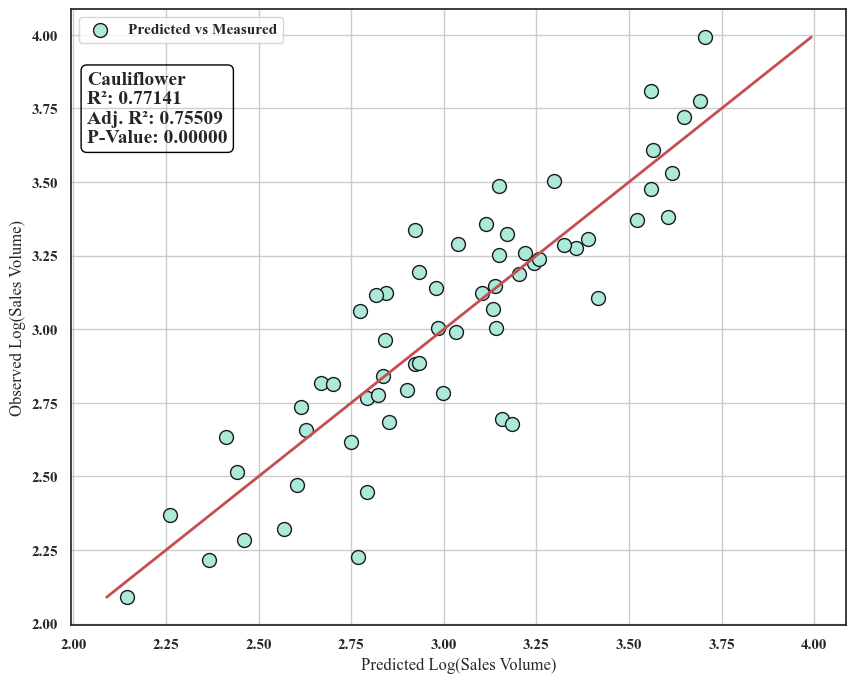


Leafy flowers 回归结果 (逐步回归):
                            OLS Regression Results                            
Dep. Variable:          Leafy flowers   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     40.53
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           2.96e-17
Time:                        13:51:13   Log-Likelihood:                 44.673
No. Observations:                  61   AIC:                            -77.35
Df Residuals:                      55   BIC:                            -64.68
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

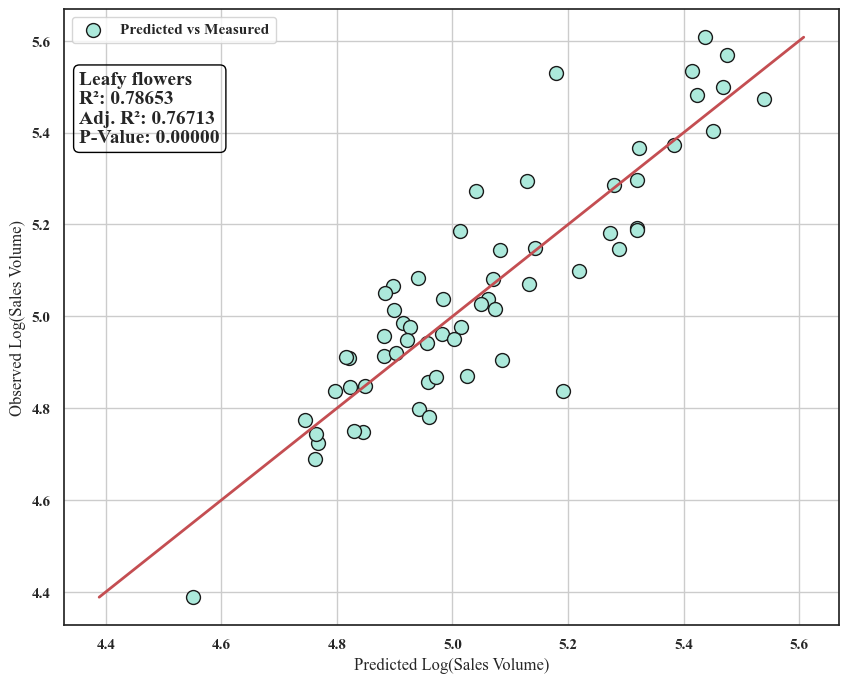


Peppers 回归结果 (逐步回归):
                            OLS Regression Results                            
Dep. Variable:                Peppers   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     63.64
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           1.25e-21
Time:                        13:51:19   Log-Likelihood:                 52.812
No. Observations:                  61   AIC:                            -93.62
Df Residuals:                      55   BIC:                            -80.96
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

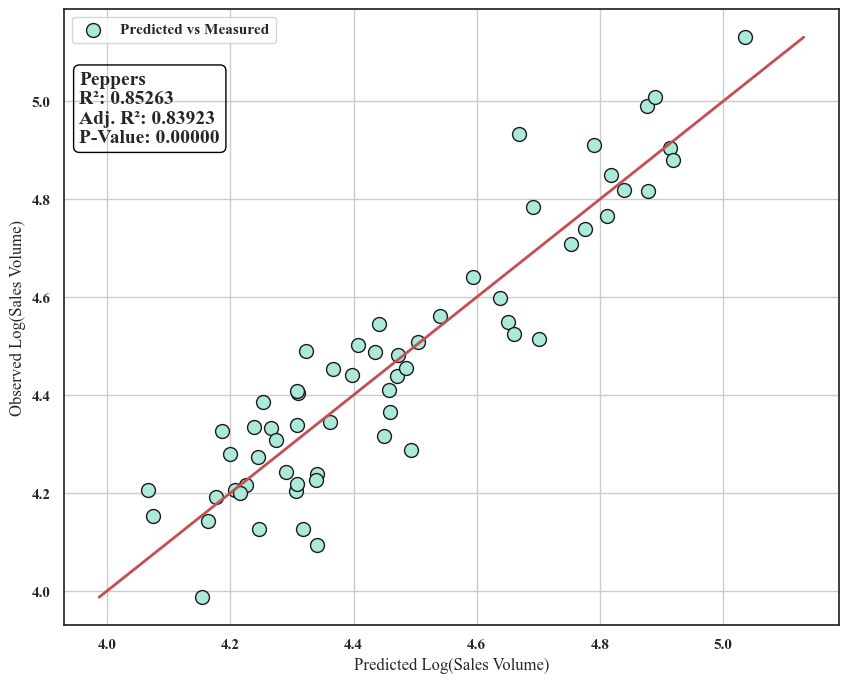


Solanaceae 回归结果 (逐步回归):
                            OLS Regression Results                            
Dep. Variable:             Solanaceae   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     33.51
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           1.28e-12
Time:                        13:51:24   Log-Likelihood:                 6.3173
No. Observations:                  61   AIC:                            -4.635
Df Residuals:                      57   BIC:                             3.809
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

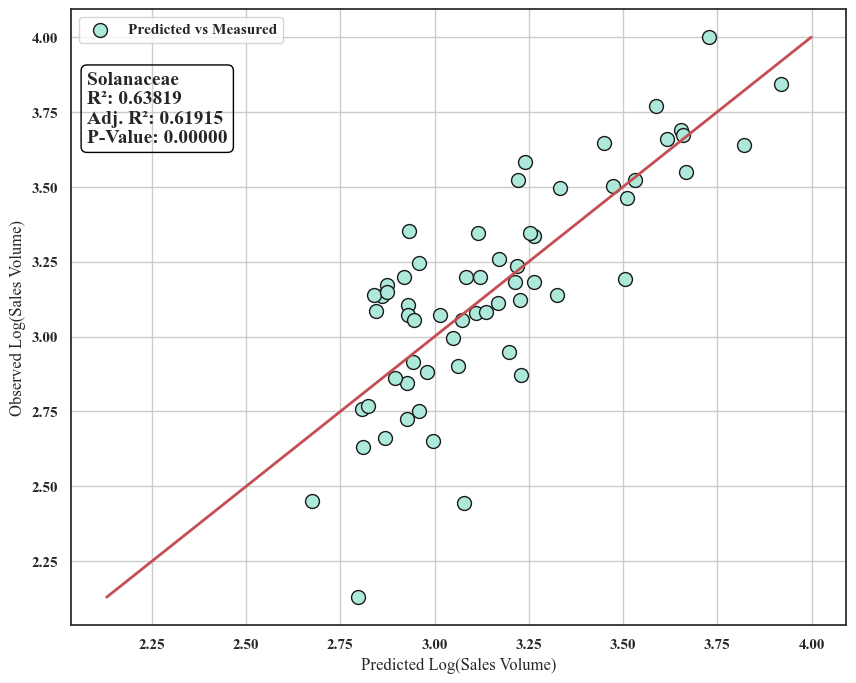


Mushrooms 回归结果 (逐步回归):
                            OLS Regression Results                            
Dep. Variable:              Mushrooms   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     78.17
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           2.99e-22
Time:                        13:51:30   Log-Likelihood:                 42.061
No. Observations:                  61   AIC:                            -74.12
Df Residuals:                      56   BIC:                            -63.57
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

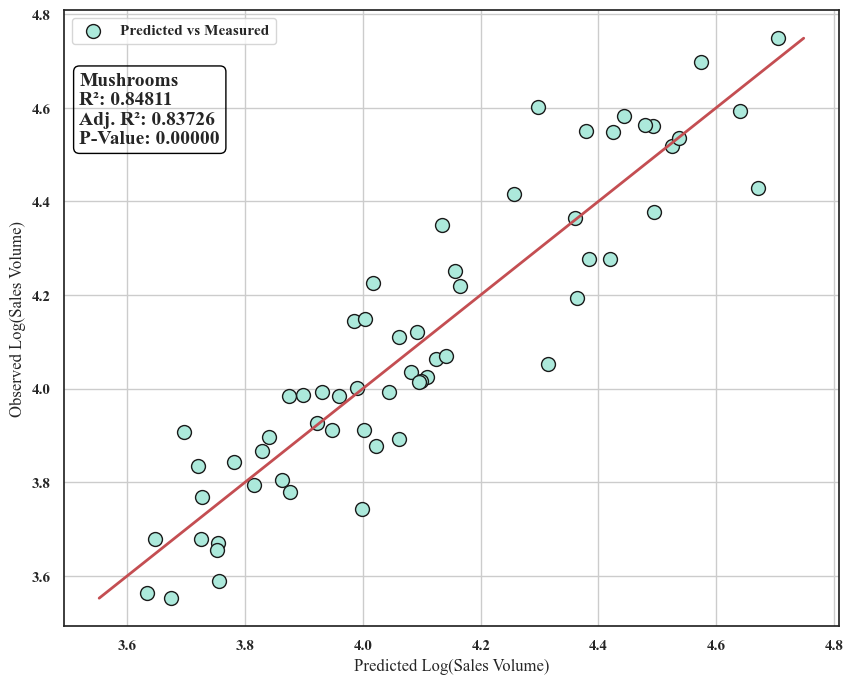


Aquatic roots and tubers 回归结果 (逐步回归):
                               OLS Regression Results                               
Dep. Variable:     Aquatic roots and tubers   R-squared:                       0.567
Model:                                  OLS   Adj. R-squared:                  0.545
Method:                       Least Squares   F-statistic:                     24.91
Date:                      Sun, 22 Dec 2024   Prob (F-statistic):           1.99e-10
Time:                              13:51:35   Log-Likelihood:                -2.2440
No. Observations:                        61   AIC:                             12.49
Df Residuals:                            57   BIC:                             20.93
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------

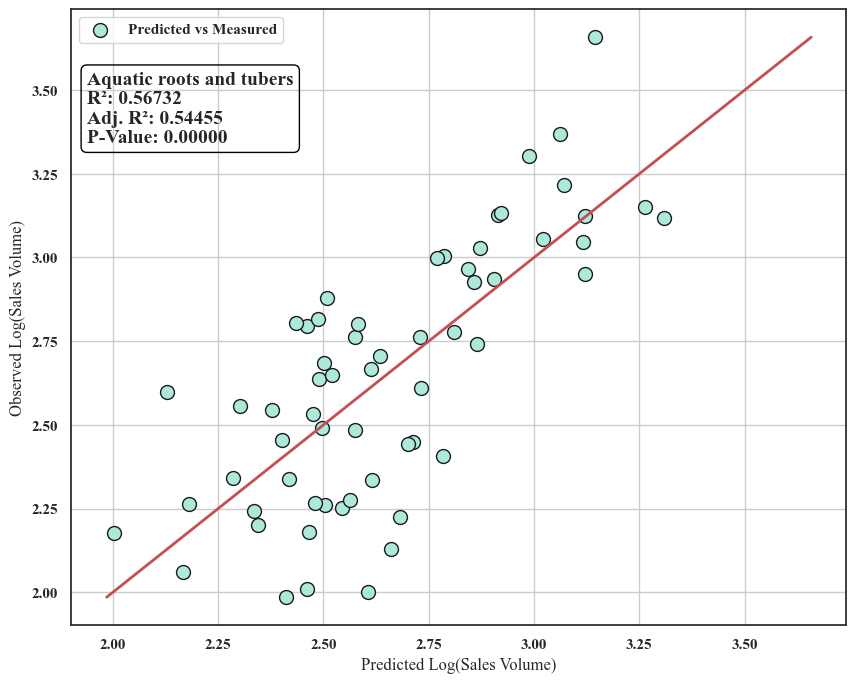

In [264]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 读取Excel文件
data_file = r'C:\Users\15549\Desktop\问题一合并后的数据(仅供参考) - 副本.xlsx'
selling_price_sheet = "销售单价"
wholesale_price_sheet = "批发价格"
sales_volume_sheet = "销量"

# 分别读取数据
selling_price = pd.read_excel(data_file, sheet_name=selling_price_sheet)
wholesale_price = pd.read_excel(data_file, sheet_name=wholesale_price_sheet)
sales_volume = pd.read_excel(data_file, sheet_name=sales_volume_sheet)

# 商品种类
categories = ['Cauliflower', 'Leafy Greens', 'Peppers', 'Solanaceous Vegetables', 'Mushrooms', 'Aquatic Roots and Tubers']

# 初始化结果存储
results = {}

# 定义逐步回归函数
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10):
    """
    Perform a forward-backward feature selection based on p-values.
    """
    included = []
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)

        if not changed:
            break

    return included

# 遍历每个商品种类
for category in categories:
    # 获取该商品的销量
    y = np.log(sales_volume[category])  # 销量取对数

    # 构造解释变量
    X = pd.DataFrame()
    X['Wholesale Price * Markup'] = np.log(wholesale_price[category] * (1 + selling_price[category]))  # 本商品价格

    # 添加其他商品的销售单价和销量作为额外解释变量
    for other_category in categories:
        if other_category != category:
            X[f'Selling Price ({other_category})'] = np.log(selling_price[other_category])
            X[f'Sales Volume ({other_category})'] = np.log(sales_volume[other_category])

    # 执行逐步回归
    selected_features = stepwise_selection(X, y)

    # 最终模型
    X_selected = sm.add_constant(X[selected_features])
    model = sm.OLS(y, X_selected).fit()

    # 保存结果
    results[category] = model

    # 输出摘要
    print(f"\n{category} 回归结果 (逐步回归):")
    print(model.summary())

    # 可视化
    plt.figure(figsize=(10, 8))
    plt.scatter(model.fittedvalues, y, color=(172 / 255, 233 / 255, 219 / 255), edgecolors='k', s=100, label='Predicted vs Measured')

    # 绘制y=x的红色实线
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', linewidth=2)

    # 添加图例
    plt.legend()

    # 在图像左上角显示模型名称和评价指标
    metrics_text = f"R²: {model.rsquared:.5f}\nAdj. R²: {model.rsquared_adj:.5f}\nP-Value: {model.f_pvalue:.5f}"

    # 在左上角显示文本框
    plt.text(0.02, 0.90, f"{category}\n{metrics_text}", transform=plt.gca().transAxes,
             fontsize=14, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='none'))

    plt.xlabel('Predicted Log(Sales Volume)')
    plt.ylabel('Observed Log(Sales Volume)')
    plt.grid(True)

    # 保存图像
    plt.savefig(f'{category}_Stepwise_Regression_Results.png', dpi=900, bbox_inches='tight')
    plt.show()

# 保存所有结果到文本文件
with open("stepwise_regression_results_summary.txt", "w") as f:
    for category, model in results.items():
        f.write(f"\n{category} 回归结果 (逐步回归):\n")
        f.write(model.summary().as_text())


In [297]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 商品分类
categories = ["Cauliflower", "Leafy flowers", "Peppers", "Solanaceae", "Mushrooms", "Aquatic roots and tubers"]

# 定义需求量公式参数（基于回归结果）
parameters = {
    "Cauliflower": {"alpha": 2.1886, "beta": -0.9857, "gamma": {"Solanaceae": 0.5908}, "delta": {"Mushrooms": 0.4195, "Leafy flowers": 0.4908}},
    "Leafy flowers": {"alpha": 3.1204, "beta": -0.6574, "gamma": {"Cauliflower": 0.3061}, "delta": {"Peppers": 0.2717, "Mushrooms": 0.3482, "Cauliflower": 0.2072}},
    "Peppers": {"alpha": 3.2775, "beta": -0.5992, "gamma": {"Mushrooms": 0.2702}, "delta": {"Mushrooms": 0.5095, "Solanaceae": 0.1585, "Cauliflower": 0.1067}},
    "Solanaceae": {"alpha": -2.9685, "beta": 0, "gamma": {"Cauliflower": 0.5727}, "delta": {"Peppers": 0.6752, "Mushrooms": 0.4111}},
    "Mushrooms": {"alpha": -0.4126, "beta": -0.3457, "gamma": {"Peppers": 0.5006}, "delta": {"Peppers": 0.7163, "Leafy flowers": 0.3453}},
    "Aquatic roots and tubers": {"alpha": -0.9428, "beta": 0, "gamma": {"Leafy flowers": -1.5807, "Solanaceae": 0.7967}, "delta": {"Peppers": 1.0462}}
}

# 每日成本、损耗率和需求量
future_costs = pd.DataFrame({
    "Cauliflower": [6.47, 8.04, 7.95, 7.83, 6.91, 8.04, 7.88, 8.04, 7.81, 8.04, 8.04, 8.04, 7.72, 8.04, 8.04],
    "Leafy flowers": [3.52, 3.54, 3.52, 3.53, 3.64, 3.74, 3.56, 3.55, 3.76, 3.57, 3.61, 3.53, 3.76, 3.61, 4.00],
    "Peppers": [5.52, 5.33, 5.37, 5.64, 5.39, 5.15, 5.24, 5.50, 5.61, 4.91, 5.36, 5.07, 5.47, 5.20, 5.32],
    "Solanaceae": [7.12, 7.19, 6.65, 7.30, 7.33, 6.66, 6.40, 6.81, 6.83, 6.00, 6.86, 7.03, 6.42, 6.25, 6.19],
    "Mushrooms": [7.35, 6.95, 6.89, 7.29, 5.91, 6.95, 7.77, 7.68, 6.94, 5.35, 7.56, 6.40, 7.39, 7.34, 7.14],
    "Aquatic roots and tubers": [16.71, 13.30, 16.34, 12.68, 14.60, 8.22, 10.42, 13.53, 13.50, 13.85, 13.68, 12.32, 11.40, 14.18, 13.11]
})

future_sales = pd.DataFrame({
    "Cauliflower": [21.67, 18.13, 17.67, 17.95, 24.89, 27.43, 25.14, 19.17, 19.95, 21.43, 22.10, 17.71, 18.77, 18.36, 17.19],
    "Leafy flowers": [139.26, 145.54, 133.97, 135.21, 160.48, 191.21, 194.40, 139.86, 138.73, 138.74, 160.39, 163.60, 155.41, 131.08, 119.99],
    "Peppers": [98.82, 108.73, 107.15, 96.95, 109.45, 150.76, 143.04, 104.28, 98.57, 112.43, 125.39, 110.70, 114.05, 100.19, 101.58],
    "Solanaceae": [27.46, 24.86, 30.04, 24.05, 27.98, 37.73, 40.07, 26.55, 26.74, 27.97, 32.64, 28.59, 30.04, 27.58, 26.56],
    "Mushrooms": [47.79, 56.21, 51.06, 47.29, 58.48, 77.50, 66.02, 50.84, 49.05, 61.15, 69.06, 56.83, 56.18, 47.44, 49.21],
    "Aquatic roots and tubers": [14.10, 15.05, 12.52, 17.76, 17.05, 20.82, 21.15, 14.74, 14.83, 22.69, 25.78, 18.84, 17.37, 17.63, 14.12]
})

loss_rate = pd.Series({
    "Cauliflower": 0.1551,
    "Leafy flowers": 0.1283,
    "Peppers": 0.0924,
    "Solanaceae": 0.0668,
    "Mushrooms": 0.0945,
    "Aquatic roots and tubers": 0.1365
})

# 定义需求函数
def demand_function(category, costs, sales, markups):
    param = parameters[category]
    p_i = costs[category] * (1 + markups[category])
    gamma_part = sum(param["gamma"].get(other, 0) * np.log(costs[other] * (1 + markups[other])) for other in categories if other != category)
    delta_part = sum(param["delta"].get(other, 0) * np.log(sales[other]) for other in categories if other != category)
    demand = np.exp(param["alpha"] - param["beta"] * np.log(p_i) + gamma_part + delta_part)
    return demand
'''
# 定义目标函数
def objective(vars, *args):
    categories, costs, sales = args
    Q, m = vars[:len(categories)], vars[len(categories):]
    revenue = sum((costs[cat] * (1 + m[i]) - costs[cat]) * min(Q[i], sales[cat]) for i, cat in enumerate(categories))
    holding_cost = sum(loss_rate[cat] * (Q[i] - sales[cat]) for i, cat in enumerate(categories))
    profit = revenue - holding_cost
    return -profit  # 最大化利润
'''
def objective(vars, *args):
    categories, costs, sales = args
    Q, m = vars[:len(categories)], vars[len(categories):]
    revenue = sum((costs[cat] * (1 + m[i]) - costs[cat]) * min(Q[i], sales[cat]) for i, cat in enumerate(categories))
    holding_cost = sum(loss_rate[cat] * (Q[i] - sales[cat]) for i, cat in enumerate(categories))
    penalty = sum(2000 * max(0, m[i] - 0.35)**2 for i in range(len(categories)))  # 惩罚过高的加成率
    profit = revenue - holding_cost- penalty
    return -profit

# 结果存储
results = []

# 遍历每日数据
for day in range(len(future_sales)):
    costs = future_costs.iloc[day].to_dict()
    sales = future_sales.iloc[day].to_dict()

    # 初始值和边界
    x0 = [sales[cat] * 1.05 for cat in categories] + [0.1 for _ in categories]  # 初始进货量和加成率
    bounds = [(sales[cat], sales[cat] * 1.5) for cat in categories] + [(0.05, 0.5) for _ in categories]  # 边界

    args = (categories, costs, sales)

    # 优化求解
    result = minimize(objective, x0, args=args, bounds=bounds, method='SLSQP')

    if result.success:
        Q_opt = result.x[:len(categories)]
        m_opt = result.x[len(categories):]
        daily_result = {
            "Date": day + 1,
            "Optimal Quantities": dict(zip(categories, Q_opt)),
            "Optimal Markups": dict(zip(categories, m_opt)),
            "Prices": {cat: costs[cat] * (1 + m) for cat, m in zip(categories, m_opt)},
            "Profit": -result.fun
        }
        results.append(daily_result)

# 将每日结果分开存储
optimal_quantities = []
optimal_markups = []
prices_and_profit = []

for r in results:
    # 每天的最优结果按不同类型存储
    quantities = {"Date": r["Date"], **r["Optimal Quantities"]}
    markups = {"Date": r["Date"], **r["Optimal Markups"]}
    prices = {"Date": r["Date"], **r["Prices"], "Profit": r["Profit"]}
    
    # 追加到列表
    optimal_quantities.append(quantities)
    optimal_markups.append(markups)
    prices_and_profit.append(prices)

# 转为 DataFrame
df_quantities = pd.DataFrame(optimal_quantities)
df_markups = pd.DataFrame(optimal_markups)
df_prices_profit = pd.DataFrame(prices_and_profit)

# 保存到 Excel 文件的不同 Sheet
output_file = "optimization_results.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    df_quantities.to_excel(writer, sheet_name="Optimal Quantities", index=False)
    df_markups.to_excel(writer, sheet_name="Optimal Markups", index=False)
    df_prices_profit.to_excel(writer, sheet_name="Prices and Profit", index=False)

print(f"结果已成功保存到文件：{output_file}")

结果已成功保存到文件：optimization_results.xlsx


In [298]:
import numpy as np
import pandas as pd
from pyswarm import pso

# 商品分类
categories = ["Cauliflower", "Leafy flowers", "Peppers", "Solanaceae", "Mushrooms", "Aquatic roots and tubers"]

# 定义需求量公式参数（基于回归结果）
parameters = {
    "Cauliflower": {"alpha": 2.1886, "beta": -0.9857, "gamma": {"Solanaceae": 0.5908}, "delta": {"Mushrooms": 0.4195, "Leafy flowers": 0.4908}},
    "Leafy flowers": {"alpha": 3.1204, "beta": -0.6574, "gamma": {"Cauliflower": 0.3061}, "delta": {"Peppers": 0.2717, "Mushrooms": 0.3482, "Cauliflower": 0.2072}},
    "Peppers": {"alpha": 3.2775, "beta": -0.5992, "gamma": {"Mushrooms": 0.2702}, "delta": {"Mushrooms": 0.5095, "Solanaceae": 0.1585, "Cauliflower": 0.1067}},
    "Solanaceae": {"alpha": -2.9685, "beta": 0, "gamma": {"Cauliflower": 0.5727}, "delta": {"Peppers": 0.6752, "Mushrooms": 0.4111}},
    "Mushrooms": {"alpha": -0.4126, "beta": -0.3457, "gamma": {"Peppers": 0.5006}, "delta": {"Peppers": 0.7163, "Leafy flowers": 0.3453}},
    "Aquatic roots and tubers": {"alpha": -0.9428, "beta": 0, "gamma": {"Leafy flowers": -1.5807, "Solanaceae": 0.7967}, "delta": {"Peppers": 1.0462}}
}

# 每日成本、损耗率和需求量
future_costs = pd.DataFrame({
    "Cauliflower": [6.47, 8.04, 7.95, 7.83, 6.91, 8.04, 7.88, 8.04, 7.81, 8.04, 8.04, 8.04, 7.72, 8.04, 8.04],
    "Leafy flowers": [3.52, 3.54, 3.52, 3.53, 3.64, 3.74, 3.56, 3.55, 3.76, 3.57, 3.61, 3.53, 3.76, 3.61, 4.00],
    "Peppers": [5.52, 5.33, 5.37, 5.64, 5.39, 5.15, 5.24, 5.50, 5.61, 4.91, 5.36, 5.07, 5.47, 5.20, 5.32],
    "Solanaceae": [7.12, 7.19, 6.65, 7.30, 7.33, 6.66, 6.40, 6.81, 6.83, 6.00, 6.86, 7.03, 6.42, 6.25, 6.19],
    "Mushrooms": [7.35, 6.95, 6.89, 7.29, 5.91, 6.95, 7.77, 7.68, 6.94, 5.35, 7.56, 6.40, 7.39, 7.34, 7.14],
    "Aquatic roots and tubers": [16.71, 13.30, 16.34, 12.68, 14.60, 8.22, 10.42, 13.53, 13.50, 13.85, 13.68, 12.32, 11.40, 14.18, 13.11]
})

future_sales = pd.DataFrame({
    "Cauliflower": [21.67, 18.13, 17.67, 17.95, 24.89, 27.43, 25.14, 19.17, 19.95, 21.43, 22.10, 17.71, 18.77, 18.36, 17.19],
    "Leafy flowers": [139.26, 145.54, 133.97, 135.21, 160.48, 191.21, 194.40, 139.86, 138.73, 138.74, 160.39, 163.60, 155.41, 131.08, 119.99],
    "Peppers": [98.82, 108.73, 107.15, 96.95, 109.45, 150.76, 143.04, 104.28, 98.57, 112.43, 125.39, 110.70, 114.05, 100.19, 101.58],
    "Solanaceae": [27.46, 24.86, 30.04, 24.05, 27.98, 37.73, 40.07, 26.55, 26.74, 27.97, 32.64, 28.59, 30.04, 27.58, 26.56],
    "Mushrooms": [47.79, 56.21, 51.06, 47.29, 58.48, 77.50, 66.02, 50.84, 49.05, 61.15, 69.06, 56.83, 56.18, 47.44, 49.21],
    "Aquatic roots and tubers": [14.10, 15.05, 12.52, 17.76, 17.05, 20.82, 21.15, 14.74, 14.83, 22.69, 25.78, 18.84, 17.37, 17.63, 14.12]
})

loss_rate = pd.Series({
    "Cauliflower": 0.1551,
    "Leafy flowers": 0.1283,
    "Peppers": 0.0924,
    "Solanaceae": 0.0668,
    "Mushrooms": 0.0945,
    "Aquatic roots and tubers": 0.1365
})

# 定义需求函数
def demand_function(category, costs, sales, markups):
    param = parameters[category]
    p_i = costs[category] * (1 + markups[category])
    gamma_part = sum(param["gamma"].get(other, 0) * np.log(costs[other] * (1 + markups[other])) for other in categories if other != category)
    delta_part = sum(param["delta"].get(other, 0) * np.log(sales[other]) for other in categories if other != category)
    demand = np.exp(param["alpha"] - param["beta"] * np.log(p_i) + gamma_part + delta_part)
    return demand

# 目标函数
def objective(vars, *args):
    categories, costs, sales = args
    Q, m = vars[:len(categories)], vars[len(categories):]
    revenue = sum((costs[cat] * (1 + m[i]) - costs[cat]) * min(Q[i], sales[cat]) for i, cat in enumerate(categories))
    holding_cost = sum(loss_rate[cat] * (Q[i] - sales[cat]) for i, cat in enumerate(categories))
    penalty = sum(2000 * max(0, m[i] - 0.35)**2 for i in range(len(categories)))  # 惩罚过高的加成率
    return -(revenue - holding_cost - penalty)  # 最大化利润

# 使用PSO优化
def optimize_day(costs, sales):
    lb = [sales[cat] for cat in categories] + [0.05 for _ in categories]
    ub = [sales[cat] * 1.5 for cat in categories] + [0.5 for _ in categories]
    x0 = [sales[cat] * 1.1 for cat in categories] + [0.1 for _ in categories]
    args = (categories, costs, sales)
    
    # PSO优化
    best_vals, _ = pso(objective, lb, ub, args=args, swarmsize=100, maxiter=200)
    Q_opt = best_vals[:len(categories)]
    m_opt = best_vals[len(categories):]
    
    result = {
        "Optimal Quantities": dict(zip(categories, Q_opt)),
        "Optimal Markups": dict(zip(categories, m_opt)),
        "Prices": {cat: costs[cat] * (1 + m) for cat, m in zip(categories, m_opt)},
        "Profit": -objective(best_vals, *args)
    }
    return result

# 逐天优化并存储结果
results = []
for day in range(len(future_sales)):
    costs = future_costs.iloc[day].to_dict()
    sales = future_sales.iloc[day].to_dict()
    daily_result = optimize_day(costs, sales)
    daily_result["Date"] = day + 1
    results.append(daily_result)

# 输出为DataFrame并保存
df_quantities = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Quantities"]} for r in results])
df_markups = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Markups"]} for r in results])
df_prices_profit = pd.DataFrame([{**{"Date": r["Date"]}, **r["Prices"], "Profit": r["Profit"]} for r in results])

output_file = "PSO_optimization_results.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df_quantities.to_excel(writer, sheet_name="Optimal Quantities", index=False)
    df_markups.to_excel(writer, sheet_name="Optimal Markups", index=False)
    df_prices_profit.to_excel(writer, sheet_name="Prices and Profit", index=False)

print(f"结果已保存到文件：{output_file}")


Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 200
Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 200
结果已保存到文件：PSO_optimization_results.xlsx


 The best solution found:                                                                           
 [ 21.68348765 139.32604097  98.9966052   27.47408007  47.92377394
  14.10691514   0.38514916   0.47231971   0.48646422   0.3987114
   0.43789926   0.40873476]

 Objective function:
 -782.1805455773858


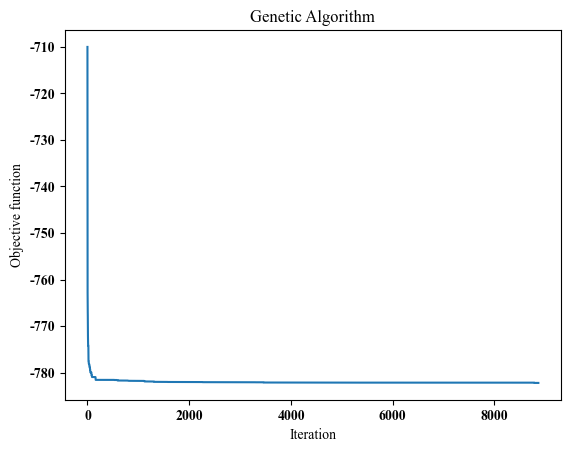

 The best solution found:                                                                           
 [ 18.13199795 145.58715368 108.78423996  24.86113444  56.21229287
  15.1059823    0.38679684   0.47871835   0.49488258   0.39463993
   0.44775534   0.40006877]

 Objective function:
 -809.4039434722667


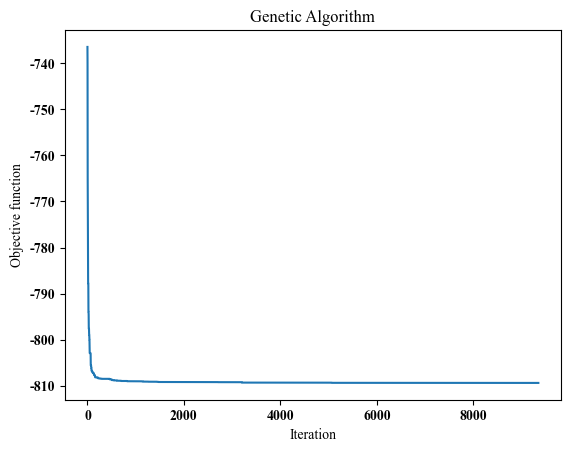

 The best solution found:                                                                           
 [ 17.69767858 134.27438114 107.17680548  30.31845265  51.08525742
  12.53322589   0.38519842   0.46781773   0.49347079   0.39991258
   0.43820672   0.401151  ]

 Objective function:
 -777.5283272950822


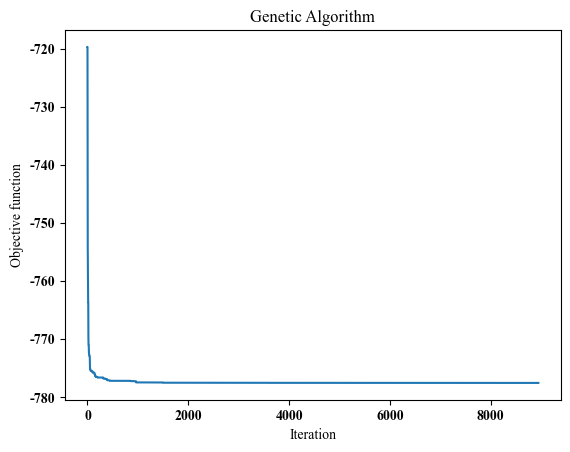

 The best solution found:                                                                           
 [ 17.98835092 135.50263214  97.07583208  24.05937514  47.44751315
  17.78177781   0.38495759   0.46912252   0.48643411   0.39379239
   0.4361164    0.40638974]

 Objective function:
 -761.8431201899476


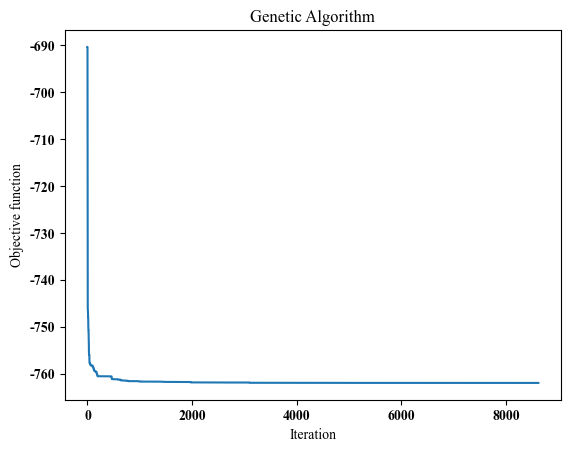

 The best solution found:                                                                           
 [ 24.89292966 160.59049937 109.5007578   27.99248056  58.49030822
  17.07911072   0.39295804   0.49604358   0.49731665   0.40100538
   0.43632715   0.41222919]

 Objective function:
 -868.7632613379316


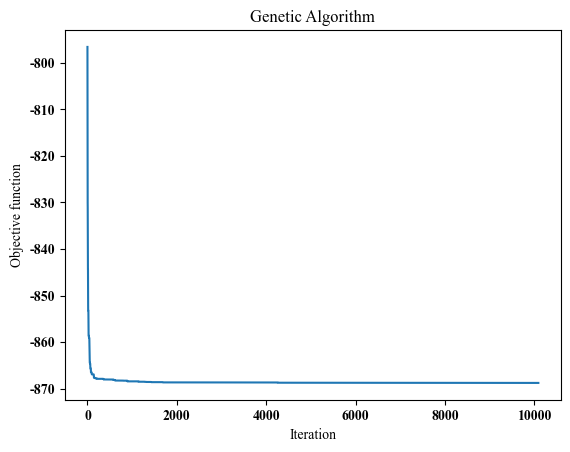

 The best solution found:                                                                           
 [ 27.47549826 191.2345394  150.83086652  37.84397078  77.51913053
  20.8474627    0.40500082   0.49881997   0.49935899   0.41282115
   0.48465065   0.39273565]

 Objective function:
 -1122.9398768817307


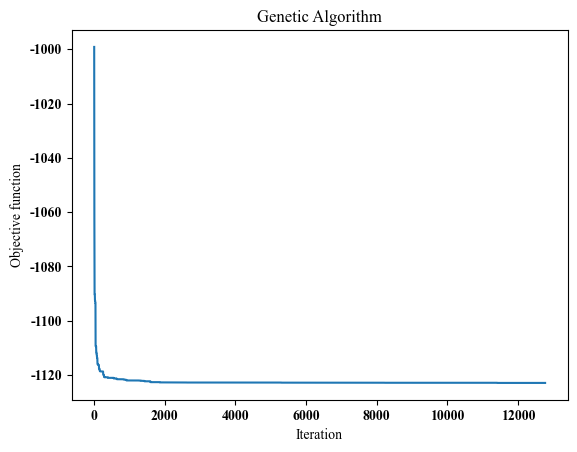

 The best solution found:                                                                           
 [ 25.14243868 194.670943   143.29425426  40.08495293  66.08245645
  21.15857411   0.39931256   0.49911698   0.49999459   0.41413213
   0.47813905   0.40517631]

 Objective function:
 -1098.505025553432


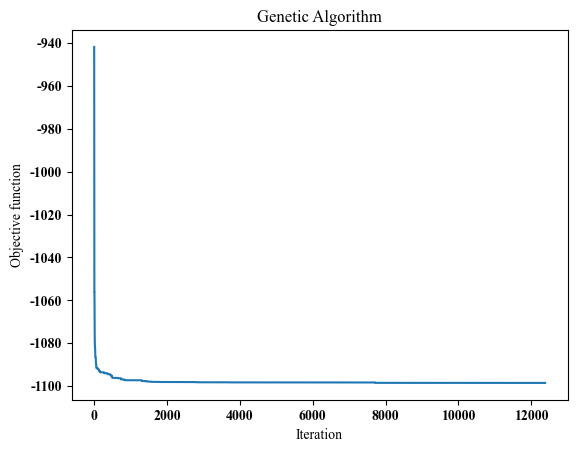

 The best solution found:                                                                           
 [ 19.18503977 139.94311957 104.30355521  26.58628927  50.88188881
  14.75974132   0.38855627   0.47391912   0.49327728   0.39530374
   0.44761963   0.40004029]

 Objective function:
 -801.1928972384137


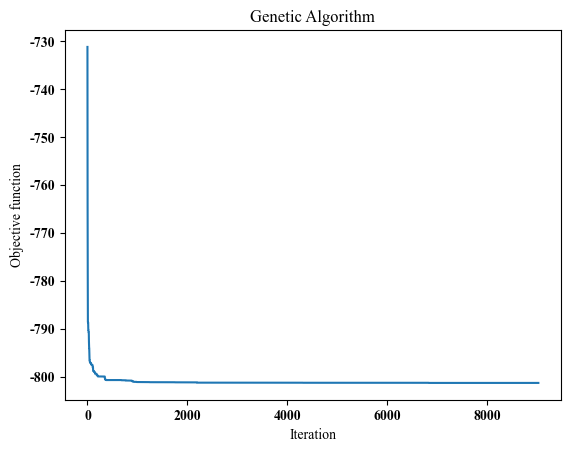

 The best solution found:                                                                           
 [ 20.00963086 138.78176618  98.69296168  26.76007251  49.06885622
  14.83513754   0.38908122   0.48035873   0.48758764   0.39618555
   0.43504657   0.4000608 ]

 Objective function:
 -782.6812802669334


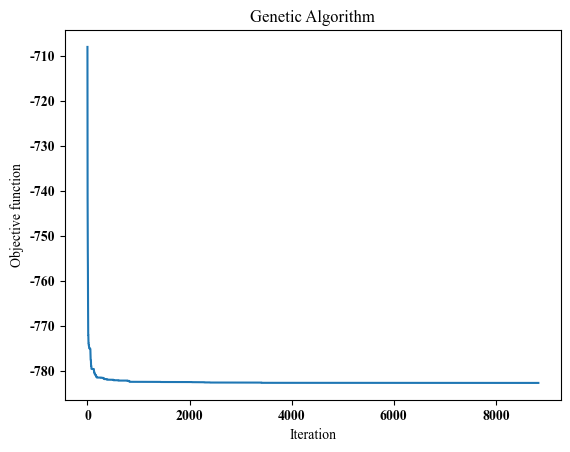

 The best solution found:                                                                           
 [ 21.44337095 138.77742213 112.45565949  27.97516206  61.17139611
  22.72813736   0.3934389    0.47384491   0.48801511   0.39195383
   0.43182172   0.42847809]

 Objective function:
 -811.7959292780934


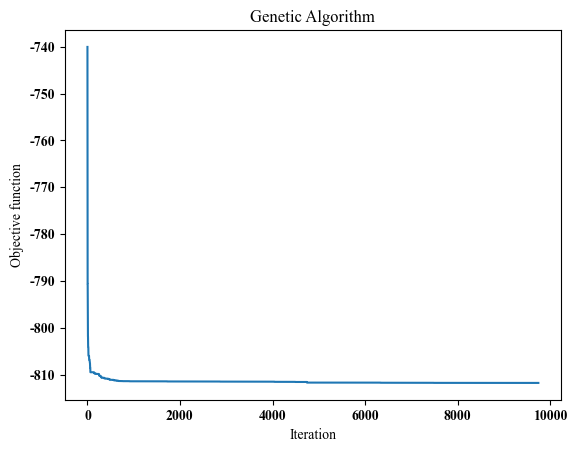

 The best solution found:                                                                           
 [ 22.10557219 160.60325636 125.80901523  32.64619023  69.08582801
  25.78063164   0.39440748   0.49476125   0.49968606   0.40569516
   0.48042717   0.43821444]

 Objective function:
 -1042.069979647076


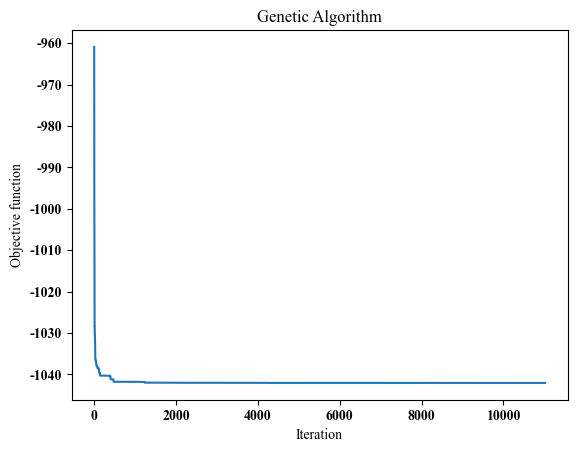

 The best solution found:                                                                           
 [ 17.71155094 163.66335534 110.71004792  28.83966868  56.84443142
  18.85916389   0.38557898   0.49398856   0.49038749   0.40015413
   0.44098502   0.4081968 ]

 Objective function:
 -839.1719345353181


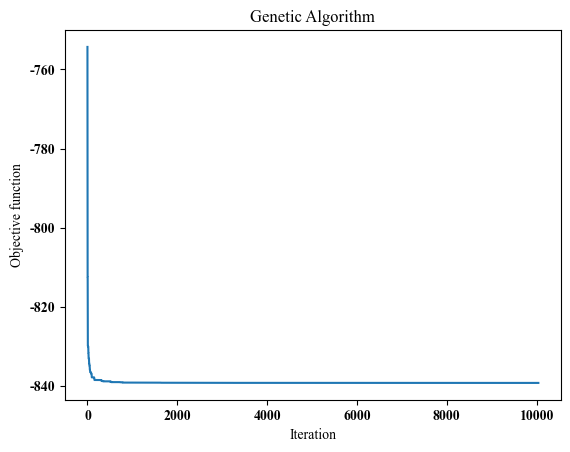

 The best solution found:                                                                           
 [ 18.80579641 155.56659822 114.17733319  30.04310451  56.22718428
  17.40657517   0.38563294   0.49601739   0.49875035   0.39794461
   0.45378805   0.39964526]

 Objective function:
 -880.6006470642008


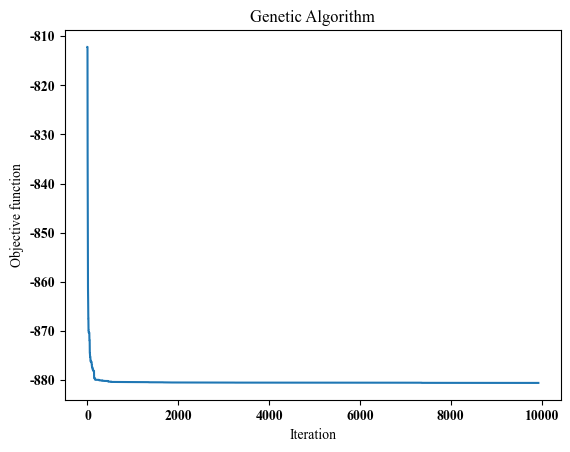

 The best solution found:                                                                           
 [ 18.36144974 131.11708263 100.35423493  27.63487648  47.59965778
  17.63877816   0.38664018   0.46808529   0.47992683   0.39321422
   0.43711057   0.4125718 ]

 Objective function:
 -760.616550411482


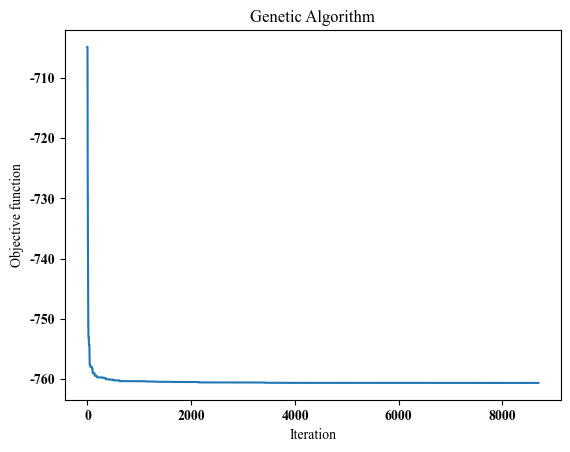

 The best solution found:                                                                           
 [ 17.19853523 120.0139932  101.75921699  26.60062894  49.30936201
  14.12160438   0.38410603   0.46982152   0.48505033   0.39146297
   0.43795636   0.39625301]

 Objective function:
 -741.5556042890652


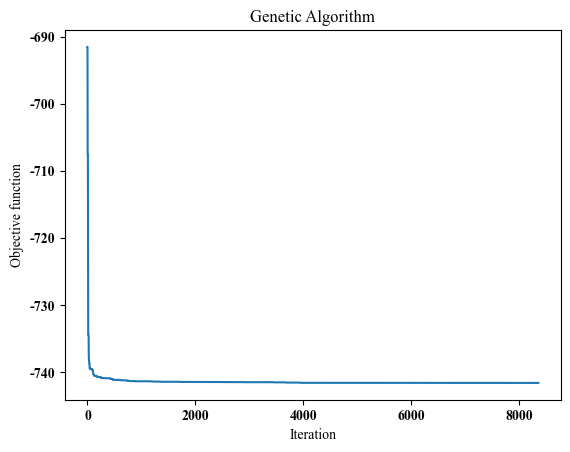

结果已保存到文件：GA_optimization_results.xlsx


In [5]:
import numpy as np
import pandas as pd
from geneticalgorithm import geneticalgorithm as ga

# 商品分类
categories = ["Cauliflower", "Leafy flowers", "Peppers", "Solanaceae", "Mushrooms", "Aquatic roots and tubers"]

# 定义需求量公式参数（基于回归结果）
parameters = {
    "Cauliflower": {"alpha": 2.1886, "beta": -0.9857, "gamma": {"Solanaceae": 0.5908}, "delta": {"Mushrooms": 0.4195, "Leafy flowers": 0.4908}},
    "Leafy flowers": {"alpha": 3.1204, "beta": -0.6574, "gamma": {"Cauliflower": 0.3061}, "delta": {"Peppers": 0.2717, "Mushrooms": 0.3482, "Cauliflower": 0.2072}},
    "Peppers": {"alpha": 3.2775, "beta": -0.5992, "gamma": {"Mushrooms": 0.2702}, "delta": {"Mushrooms": 0.5095, "Solanaceae": 0.1585, "Cauliflower": 0.1067}},
    "Solanaceae": {"alpha": -2.9685, "beta": 0, "gamma": {"Cauliflower": 0.5727}, "delta": {"Peppers": 0.6752, "Mushrooms": 0.4111}},
    "Mushrooms": {"alpha": -0.4126, "beta": -0.3457, "gamma": {"Peppers": 0.5006}, "delta": {"Peppers": 0.7163, "Leafy flowers": 0.3453}},
    "Aquatic roots and tubers": {"alpha": -0.9428, "beta": 0, "gamma": {"Leafy flowers": -1.5807, "Solanaceae": 0.7967}, "delta": {"Peppers": 1.0462}}
}

# 每日成本、损耗率和需求量
future_costs = pd.DataFrame({
    "Cauliflower": [6.47, 8.04, 7.95, 7.83, 6.91, 8.04, 7.88, 8.04, 7.81, 8.04, 8.04, 8.04, 7.72, 8.04, 8.04],
    "Leafy flowers": [3.52, 3.54, 3.52, 3.53, 3.64, 3.74, 3.56, 3.55, 3.76, 3.57, 3.61, 3.53, 3.76, 3.61, 4.00],
    "Peppers": [5.52, 5.33, 5.37, 5.64, 5.39, 5.15, 5.24, 5.50, 5.61, 4.91, 5.36, 5.07, 5.47, 5.20, 5.32],
    "Solanaceae": [7.12, 7.19, 6.65, 7.30, 7.33, 6.66, 6.40, 6.81, 6.83, 6.00, 6.86, 7.03, 6.42, 6.25, 6.19],
    "Mushrooms": [7.35, 6.95, 6.89, 7.29, 5.91, 6.95, 7.77, 7.68, 6.94, 5.35, 7.56, 6.40, 7.39, 7.34, 7.14],
    "Aquatic roots and tubers": [16.71, 13.30, 16.34, 12.68, 14.60, 8.22, 10.42, 13.53, 13.50, 13.85, 13.68, 12.32, 11.40, 14.18, 13.11]
})

future_sales = pd.DataFrame({
    "Cauliflower": [21.67, 18.13, 17.67, 17.95, 24.89, 27.43, 25.14, 19.17, 19.95, 21.43, 22.10, 17.71, 18.77, 18.36, 17.19],
    "Leafy flowers": [139.26, 145.54, 133.97, 135.21, 160.48, 191.21, 194.40, 139.86, 138.73, 138.74, 160.39, 163.60, 155.41, 131.08, 119.99],
    "Peppers": [98.82, 108.73, 107.15, 96.95, 109.45, 150.76, 143.04, 104.28, 98.57, 112.43, 125.39, 110.70, 114.05, 100.19, 101.58],
    "Solanaceae": [27.46, 24.86, 30.04, 24.05, 27.98, 37.73, 40.07, 26.55, 26.74, 27.97, 32.64, 28.59, 30.04, 27.58, 26.56],
    "Mushrooms": [47.79, 56.21, 51.06, 47.29, 58.48, 77.50, 66.02, 50.84, 49.05, 61.15, 69.06, 56.83, 56.18, 47.44, 49.21],
    "Aquatic roots and tubers": [14.10, 15.05, 12.52, 17.76, 17.05, 20.82, 21.15, 14.74, 14.83, 22.69, 25.78, 18.84, 17.37, 17.63, 14.12]
})

loss_rate = pd.Series({
    "Cauliflower": 0.1551,
    "Leafy flowers": 0.1283,
    "Peppers": 0.0924,
    "Solanaceae": 0.0668,
    "Mushrooms": 0.0945,
    "Aquatic roots and tubers": 0.1365
})

# 定义需求函数
def demand_function(category, costs, sales, markups):
    param = parameters[category]
    p_i = costs[category] * (1 + markups[category])
    gamma_part = sum(param["gamma"].get(other, 0) * np.log(costs[other] * (1 + markups[other])) for other in categories if other != category)
    delta_part = sum(param["delta"].get(other, 0) * np.log(sales[other]) for other in categories if other != category)
    demand = np.exp(param["alpha"] - param["beta"] * np.log(p_i) + gamma_part + delta_part)
    return demand

# 目标函数
def objective(vars, *args):
    categories, costs, sales = args
    Q, m = vars[:len(categories)], vars[len(categories):]
    revenue = sum((costs[cat] * (1 + m[i]) - costs[cat]) * min(Q[i], sales[cat]) for i, cat in enumerate(categories))
    holding_cost = sum(loss_rate[cat] * (Q[i] - sales[cat]) for i, cat in enumerate(categories))
    penalty = sum(2000 * max(0, m[i] - 0.35)**2 for i in range(len(categories)))  # 惩罚过高的加成率
    return -(revenue - holding_cost - penalty)  # 最大化利润

# 使用GA优化
def optimize_day(costs, sales):
    lb = [sales[cat] for cat in categories] + [0.05 for _ in categories]
    ub = [sales[cat] * 1.5 for cat in categories] + [0.5 for _ in categories]
    boundaries = np.array([lb, ub]).T  # 转置以匹配 GA 的输入格式

    def fitness_function(vars):
        Q, m = vars[:len(categories)], vars[len(categories):]
        revenue = sum((costs[cat] * (1 + m[i]) - costs[cat]) * min(Q[i], sales[cat]) for i, cat in enumerate(categories))
        holding_cost = sum(loss_rate[cat] * (Q[i] - sales[cat]) for i, cat in enumerate(categories))
        penalty = sum(2000 * max(0, m[i] - 0.35)**2 for i in range(len(categories)))  # 惩罚过高的加成率
        profit = revenue - holding_cost - penalty
        return -profit  # 最大化利润

    model = ga(function=fitness_function,
               dimension=len(categories) * 2,
               variable_type='real',
               variable_boundaries=boundaries)

    model.run()
    solution = model.output_dict['variable']
    Q_opt = solution[:len(categories)]
    m_opt = solution[len(categories):]
    
    result = {
        "Optimal Quantities": dict(zip(categories, Q_opt)),
        "Optimal Markups": dict(zip(categories, m_opt)),
        "Prices": {cat: costs[cat] * (1 + m) for cat, m in zip(categories, m_opt)},
        "Profit": -fitness_function(solution)
    }
    return result

# 逐天优化并存储结果
results = []
for day in range(len(future_sales)):
    costs = future_costs.iloc[day].to_dict()
    sales = future_sales.iloc[day].to_dict()
    daily_result = optimize_day(costs, sales)
    daily_result["Date"] = day + 1
    results.append(daily_result)

# 输出为DataFrame并保存
df_quantities = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Quantities"]} for r in results])
df_markups = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Markups"]} for r in results])
df_prices_profit = pd.DataFrame([{**{"Date": r["Date"]}, **r["Prices"], "Profit": r["Profit"]} for r in results])

output_file = "GA_optimization_results.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df_quantities.to_excel(writer, sheet_name="Optimal Quantities", index=False)
    df_markups.to_excel(writer, sheet_name="Optimal Markups", index=False)
    df_prices_profit.to_excel(writer, sheet_name="Prices and Profit", index=False)

print(f"结果已保存到文件：{output_file}")


In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# 商品分类
categories = ["Cauliflower", "Leafy flowers", "Peppers", "Solanaceae", "Mushrooms", "Aquatic roots and tubers"]

# 定义需求量公式参数（基于回归结果）
parameters = {
    "Cauliflower": {"alpha": 2.1886, "beta": -0.9857, "gamma": {"Solanaceae": 0.5908}, "delta": {"Mushrooms": 0.4195, "Leafy flowers": 0.4908}},
    "Leafy flowers": {"alpha": 3.1204, "beta": -0.6574, "gamma": {"Cauliflower": 0.3061}, "delta": {"Peppers": 0.2717, "Mushrooms": 0.3482, "Cauliflower": 0.2072}},
    "Peppers": {"alpha": 3.2775, "beta": -0.5992, "gamma": {"Mushrooms": 0.2702}, "delta": {"Mushrooms": 0.5095, "Solanaceae": 0.1585, "Cauliflower": 0.1067}},
    "Solanaceae": {"alpha": -2.9685, "beta": 0, "gamma": {"Cauliflower": 0.5727}, "delta": {"Peppers": 0.6752, "Mushrooms": 0.4111}},
    "Mushrooms": {"alpha": -0.4126, "beta": -0.3457, "gamma": {"Peppers": 0.5006}, "delta": {"Peppers": 0.7163, "Leafy flowers": 0.3453}},
    "Aquatic roots and tubers": {"alpha": -0.9428, "beta": 0, "gamma": {"Leafy flowers": -1.5807, "Solanaceae": 0.7967}, "delta": {"Peppers": 1.0462}}
}

# 每日成本、损耗率和需求量
future_costs = pd.DataFrame({
    "Cauliflower": [6.47, 8.04, 7.95, 7.83, 6.91, 8.04, 7.88, 8.04, 7.81, 8.04, 8.04, 8.04, 7.72, 8.04, 8.04],
    "Leafy flowers": [3.52, 3.54, 3.52, 3.53, 3.64, 3.74, 3.56, 3.55, 3.76, 3.57, 3.61, 3.53, 3.76, 3.61, 4.00],
    "Peppers": [5.52, 5.33, 5.37, 5.64, 5.39, 5.15, 5.24, 5.50, 5.61, 4.91, 5.36, 5.07, 5.47, 5.20, 5.32],
    "Solanaceae": [7.12, 7.19, 6.65, 7.30, 7.33, 6.66, 6.40, 6.81, 6.83, 6.00, 6.86, 7.03, 6.42, 6.25, 6.19],
    "Mushrooms": [7.35, 6.95, 6.89, 7.29, 5.91, 6.95, 7.77, 7.68, 6.94, 5.35, 7.56, 6.40, 7.39, 7.34, 7.14],
    "Aquatic roots and tubers": [16.71, 13.30, 16.34, 12.68, 14.60, 8.22, 10.42, 13.53, 13.50, 13.85, 13.68, 12.32, 11.40, 14.18, 13.11]
})

future_sales = pd.DataFrame({
    "Cauliflower": [21.67, 18.13, 17.67, 17.95, 24.89, 27.43, 25.14, 19.17, 19.95, 21.43, 22.10, 17.71, 18.77, 18.36, 17.19],
    "Leafy flowers": [139.26, 145.54, 133.97, 135.21, 160.48, 191.21, 194.40, 139.86, 138.73, 138.74, 160.39, 163.60, 155.41, 131.08, 119.99],
    "Peppers": [98.82, 108.73, 107.15, 96.95, 109.45, 150.76, 143.04, 104.28, 98.57, 112.43, 125.39, 110.70, 114.05, 100.19, 101.58],
    "Solanaceae": [27.46, 24.86, 30.04, 24.05, 27.98, 37.73, 40.07, 26.55, 26.74, 27.97, 32.64, 28.59, 30.04, 27.58, 26.56],
    "Mushrooms": [47.79, 56.21, 51.06, 47.29, 58.48, 77.50, 66.02, 50.84, 49.05, 61.15, 69.06, 56.83, 56.18, 47.44, 49.21],
    "Aquatic roots and tubers": [14.10, 15.05, 12.52, 17.76, 17.05, 20.82, 21.15, 14.74, 14.83, 22.69, 25.78, 18.84, 17.37, 17.63, 14.12]
})

loss_rate = pd.Series({
    "Cauliflower": 0.1551,
    "Leafy flowers": 0.1283,
    "Peppers": 0.0924,
    "Solanaceae": 0.0668,
    "Mushrooms": 0.0945,
    "Aquatic roots and tubers": 0.1365
})

# 定义需求函数
def demand_function(category, costs, sales, markups):
    param = parameters[category]
    p_i = costs[category] * (1 + markups[category])
    gamma_part = sum(param["gamma"].get(other, 0) * np.log(costs[other] * (1 + markups[other])) for other in categories if other != category)
    delta_part = sum(param["delta"].get(other, 0) * np.log(sales[other]) for other in categories if other != category)
    demand = np.exp(param["alpha"] - param["beta"] * np.log(p_i) + gamma_part + delta_part)
    return demand

# 目标函数
def objective(vars, *args):
    categories, costs, sales = args
    Q, m = vars[:len(categories)], vars[len(categories):]
    revenue = sum((costs[cat] * (1 + m[i]) - costs[cat]) * min(Q[i], sales[cat]) for i, cat in enumerate(categories))
    holding_cost = sum(loss_rate[cat] * (Q[i] - sales[cat]) for i, cat in enumerate(categories))
    penalty = sum(2000 * max(0, m[i] - 0.35)**2 for i in range(len(categories)))  # 惩罚过高的加成率
    return -(revenue - holding_cost - penalty)  # 最大化利润

# 使用模拟退火优化
def optimize_day(costs, sales):
    lb = [sales[cat] for cat in categories] + [0.05 for _ in categories]
    ub = [sales[cat] * 1.5 for cat in categories] + [0.5 for _ in categories]

    def bounds_transform(x):
        return np.clip(x, lb, ub)

    args = (categories, costs, sales)

    def sa_objective(x):
        return objective(x, *args)

    result = dual_annealing(sa_objective, bounds=list(zip(lb, ub)))
    Q_opt = result.x[:len(categories)]
    m_opt = result.x[len(categories):]

    result_data = {
        "Optimal Quantities": dict(zip(categories, Q_opt)),
        "Optimal Markups": dict(zip(categories, m_opt)),
        "Prices": {cat: costs[cat] * (1 + m) for cat, m in zip(categories, m_opt)},
        "Profit": -result.fun
    }
    return result_data

# 逐天优化并存储结果
results = []
for day in range(len(future_sales)):
    costs = future_costs.iloc[day].to_dict()
    sales = future_sales.iloc[day].to_dict()
    daily_result = optimize_day(costs, sales)
    daily_result["Date"] = day + 1
    results.append(daily_result)

# 输出为DataFrame并保存
df_quantities = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Quantities"]} for r in results])
df_markups = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Markups"]} for r in results])
df_prices_profit = pd.DataFrame([{**{"Date": r["Date"]}, **r["Prices"], "Profit": r["Profit"]} for r in results])

output_file = "SA_optimization_results.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df_quantities.to_excel(writer, sheet_name="Optimal Quantities", index=False)
    df_markups.to_excel(writer, sheet_name="Optimal Markups", index=False)
    df_prices_profit.to_excel(writer, sheet_name="Prices and Profit", index=False)

print(f"结果已保存到文件：{output_file}")


结果已保存到文件：SA_optimization_results.xlsx


In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 商品分类
categories = ["Cauliflower", "Leafy flowers", "Peppers", "Solanaceae", "Mushrooms", "Aquatic roots and tubers"]

# 定义需求量公式参数（基于回归结果）
parameters = {
    "Cauliflower": {"alpha": 2.1886, "beta": -0.9857, "gamma": {"Solanaceae": 0.5908}, "delta": {"Mushrooms": 0.4195, "Leafy flowers": 0.4908}},
    "Leafy flowers": {"alpha": 3.1204, "beta": -0.6574, "gamma": {"Cauliflower": 0.3061}, "delta": {"Peppers": 0.2717, "Mushrooms": 0.3482, "Cauliflower": 0.2072}},
    "Peppers": {"alpha": 3.2775, "beta": -0.5992, "gamma": {"Mushrooms": 0.2702}, "delta": {"Mushrooms": 0.5095, "Solanaceae": 0.1585, "Cauliflower": 0.1067}},
    "Solanaceae": {"alpha": -2.9685, "beta": 0, "gamma": {"Cauliflower": 0.5727}, "delta": {"Peppers": 0.6752, "Mushrooms": 0.4111}},
    "Mushrooms": {"alpha": -0.4126, "beta": -0.3457, "gamma": {"Peppers": 0.5006}, "delta": {"Peppers": 0.7163, "Leafy flowers": 0.3453}},
    "Aquatic roots and tubers": {"alpha": -0.9428, "beta": 0, "gamma": {"Leafy flowers": -1.5807, "Solanaceae": 0.7967}, "delta": {"Peppers": 1.0462}}
}

# 每日成本、损耗率和需求量
future_costs = pd.DataFrame({
    "Cauliflower": [6.47, 8.04, 7.95, 7.83, 6.91, 8.04, 7.88, 8.04, 7.81, 8.04, 8.04, 8.04, 7.72, 8.04, 8.04],
    "Leafy flowers": [3.52, 3.54, 3.52, 3.53, 3.64, 3.74, 3.56, 3.55, 3.76, 3.57, 3.61, 3.53, 3.76, 3.61, 4.00],
    "Peppers": [5.52, 5.33, 5.37, 5.64, 5.39, 5.15, 5.24, 5.50, 5.61, 4.91, 5.36, 5.07, 5.47, 5.20, 5.32],
    "Solanaceae": [7.12, 7.19, 6.65, 7.30, 7.33, 6.66, 6.40, 6.81, 6.83, 6.00, 6.86, 7.03, 6.42, 6.25, 6.19],
    "Mushrooms": [7.35, 6.95, 6.89, 7.29, 5.91, 6.95, 7.77, 7.68, 6.94, 5.35, 7.56, 6.40, 7.39, 7.34, 7.14],
    "Aquatic roots and tubers": [16.71, 13.30, 16.34, 12.68, 14.60, 8.22, 10.42, 13.53, 13.50, 13.85, 13.68, 12.32, 11.40, 14.18, 13.11]
})

future_sales = pd.DataFrame({
    "Cauliflower": [21.67, 18.13, 17.67, 17.95, 24.89, 27.43, 25.14, 19.17, 19.95, 21.43, 22.10, 17.71, 18.77, 18.36, 17.19],
    "Leafy flowers": [139.26, 145.54, 133.97, 135.21, 160.48, 191.21, 194.40, 139.86, 138.73, 138.74, 160.39, 163.60, 155.41, 131.08, 119.99],
    "Peppers": [98.82, 108.73, 107.15, 96.95, 109.45, 150.76, 143.04, 104.28, 98.57, 112.43, 125.39, 110.70, 114.05, 100.19, 101.58],
    "Solanaceae": [27.46, 24.86, 30.04, 24.05, 27.98, 37.73, 40.07, 26.55, 26.74, 27.97, 32.64, 28.59, 30.04, 27.58, 26.56],
    "Mushrooms": [47.79, 56.21, 51.06, 47.29, 58.48, 77.50, 66.02, 50.84, 49.05, 61.15, 69.06, 56.83, 56.18, 47.44, 49.21],
    "Aquatic roots and tubers": [14.10, 15.05, 12.52, 17.76, 17.05, 20.82, 21.15, 14.74, 14.83, 22.69, 25.78, 18.84, 17.37, 17.63, 14.12]
})

loss_rate = pd.Series({
    "Cauliflower": 0.1551,
    "Leafy flowers": 0.1283,
    "Peppers": 0.0924,
    "Solanaceae": 0.0668,
    "Mushrooms": 0.0945,
    "Aquatic roots and tubers": 0.1365
})

# 定义需求函数
def demand_function(category, costs, sales, markups):
    param = parameters[category]
    p_i = costs[category] * (1 + markups[category])
    gamma_part = sum(param["gamma"].get(other, 0) * np.log(costs[other] * (1 + markups[other])) for other in categories if other != category)
    delta_part = sum(param["delta"].get(other, 0) * np.log(sales[other]) for other in categories if other != category)
    demand = np.exp(param["alpha"] - param["beta"] * np.log(p_i) + gamma_part + delta_part)
    return demand

# 目标函数
def objective(vars, *args):
    categories, costs, sales = args
    Q, m = vars[:len(categories)], vars[len(categories):]
    revenue = sum((costs[cat] * (1 + m[i]) - costs[cat]) * min(Q[i], sales[cat]) for i, cat in enumerate(categories))
    holding_cost = sum(loss_rate[cat] * (Q[i] - sales[cat]) for i, cat in enumerate(categories))
    penalty = sum(2000 * max(0, m[i] - 0.35)**2 for i in range(len(categories)))  # 惩罚过高的加成率
    return -(revenue - holding_cost - penalty)  # 最大化利润

# 使用梯度下降优化
def gradient_descent_optimize_day(costs, sales):
    x0 = [sales[cat] * 1.1 for cat in categories] + [0.1 for _ in categories]  # 初始值
    bounds = [(sales[cat], sales[cat] * 1.5) for cat in categories] + [(0.05, 0.5) for _ in categories]
    args = (categories, costs, sales)

    result = minimize(objective, x0, args=args, bounds=bounds, method="L-BFGS-B")

    Q_opt = result.x[:len(categories)]
    m_opt = result.x[len(categories):]

    result_dict = {
        "Optimal Quantities": dict(zip(categories, Q_opt)),
        "Optimal Markups": dict(zip(categories, m_opt)),
        "Prices": {cat: costs[cat] * (1 + m) for cat, m in zip(categories, m_opt)},
        "Profit": -result.fun
    }
    return result_dict

# 逐天优化并存储结果
results = []
for day in range(len(future_sales)):
    costs = future_costs.iloc[day].to_dict()
    sales = future_sales.iloc[day].to_dict()
    daily_result = gradient_descent_optimize_day(costs, sales)
    daily_result["Date"] = day + 1
    results.append(daily_result)

# 输出为DataFrame并保存
df_quantities = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Quantities"]} for r in results])
df_markups = pd.DataFrame([{**{"Date": r["Date"]}, **r["Optimal Markups"]} for r in results])
df_prices_profit = pd.DataFrame([{**{"Date": r["Date"]}, **r["Prices"], "Profit": r["Profit"]} for r in results])

output_file = "Gradient_Descent_optimization_results.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df_quantities.to_excel(writer, sheet_name="Optimal Quantities", index=False)
    df_markups.to_excel(writer, sheet_name="Optimal Markups", index=False)
    df_prices_profit.to_excel(writer, sheet_name="Prices and Profit", index=False)

print(f"结果已保存到文件：{output_file}")


结果已保存到文件：Gradient_Descent_optimization_results.xlsx
